In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# face extractor

In [137]:
kaggle = False
if kaggle:
    !pip install ../input/facenet-pytorch-vggface2/facenet_pytorch-2.0.1-py3-none-any.whl
    !pip install ../input/dfdc-model/codes/pkgs/efficientnet_pytorch-0.6.1/efficientnet_pytorch-0.6.1

import sys, os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import time
import torch
import random
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from torchvision.transforms import Normalize, RandomHorizontalFlip, ToTensor, ToPILImage, Compose, Resize
from sklearn.metrics import log_loss
import pathlib
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

if kaggle:
    sys.path += ["/kaggle/input/dfdc-model/codes/pkgs", "/kaggle/input/dfdc-model/codes/utils"]
    blaze_weight = "/kaggle/input/dfdc-model/codes/pkgs/blazeface.pth"
    anchors = "/kaggle/input/dfdc-model/codes/pkgs/anchors.npy"
    from engine import Inference_model, BlazeFace_extractor, FastDataset
else:
    blaze_weight = "pkgs/blazeface.pth"
    anchors = "pkgs/anchors.npy"
    from utils.engine import Inference_model, BlazeFace_extractor, FastDataset, show, Cache_loader, MTCNN_extractor

In [138]:
class Model1(Inference_model):
    def __init__(self, model_path = "/home/kailu/best_model.pth"):
        checkpoint = torch.load(model_path, map_location=device)
        self.model = checkpoint['model']
        self.model.eval()
        
    
    def TTA(self, pil_img):
        assert pil_img.size == (224, 224)
        return [pil_img]
    
    
    def predict(self, batch):
        with torch.no_grad():
            batch = batch.to(device)
            y_pred = torch.sigmoid(self.model(batch))
            ret = self.give_predict(y_pred.detach().cpu().squeeze().numpy())
        return ret

In [139]:
def predict_on_all(video_paths, video_lables, face_extractor, models, sample_number = 13, use_cache = False):
    if not use_cache:
        ds = FastDataset(video_paths, sample_rate = sample_number)
        loader = DataLoader(ds, batch_size=1, num_workers=8, drop_last=False)
    else:
        loader = Cache_loader(video_paths)
    
    predicts = []
    for batch in tqdm(loader):
        if not use_cache:
            frames = batch[0].data.numpy()
            faces = face_extractor.get_faces(frames)
        else:
            faces = np.array(batch)
            
        if len(faces) == 0 or faces is None:
            predicts.append(0.5)
            continue
        np.random.shuffle(faces)
        pils = [Image.fromarray(face).resize((224, 224))  for face in faces[:sample_number] ]

        answers = []
        for model in models:
            tr = model.data_transform()
            batch = torch.stack([tr(p) for img in pils for p in model.tta(img)])
            answers.append(model.predict(batch))
        predicts.append(np.mean(answers))

    if len(video_lables) == len(video_paths):
        print(f"loss = {log_loss(video_lables, predicts, labels=[0,1])}")
    return predicts

def gen_data(datadf):
    return  ["/data1/data/deepfake/dfdc_train/" + fn for fn in datadf.index], [0 if la=='REAL' else 1 for la in datadf.label]

In [140]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
speed_test = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using {device}")

if kaggle:
    filenames = glob.glob('/kaggle/input/deepfake-detection-challenge/test_videos/*.mp4')
    labels = []
    models = [Model1("/kaggle/input/dfdc-model/best_model.pth")]
else:
    base = '/data/deepfake/'
    metadata = pd.read_json(base + 'metadata/metadata_half_dropped.json').T
    df = metadata[((metadata['split_kailu'] == 'validation') | (metadata['split_kailu'] == 'test'))]
    df = pd.concat([df[df["label"] == "REAL"].sample(2000), df[df["label"] == "FAKE"].sample(2000)])
    filenames, labels = gen_data(df)
    models = [Model1("/home/kailu/best_model_dropped.pth")]

using cuda:0


In [155]:
face_extractor = BlazeFace_extractor(blaze_weight, anchors, scale=1.18)
# face_extractor = MTCNN_extractor(down_sample=4)

In [156]:
if speed_test:
    testnum = 100
    start = time.time()
    if kaggle:
        test_filenames, test_labels = filenames[:testnum], []
    else:
        test_filenames, test_labels = gen_data(df.sample(testnum))
    ret = predict_on_all(test_filenames, video_lables=test_labels, models=models, face_extractor=face_extractor)
    time_dur = time.time()-start
    print(f"totally {time_dur} s used, {time_dur/testnum} s per video, mean = {np.mean(ret)}")









  0%|          | 0/100 [00:00<?, ?it/s]







  1%|          | 1/100 [00:07<12:06,  7.34s/it]







  2%|▏         | 2/100 [00:09<09:34,  5.86s/it]







  3%|▎         | 3/100 [00:10<06:47,  4.20s/it]







  4%|▍         | 4/100 [00:11<05:10,  3.23s/it]







  5%|▌         | 5/100 [00:11<03:43,  2.36s/it]







  6%|▌         | 6/100 [00:12<03:00,  1.92s/it]







  7%|▋         | 7/100 [00:13<02:37,  1.69s/it]







  8%|▊         | 8/100 [00:14<02:13,  1.45s/it]







  9%|▉         | 9/100 [00:15<01:57,  1.29s/it]







 10%|█         | 10/100 [00:16<01:45,  1.18s/it]







 11%|█         | 11/100 [00:17<01:38,  1.10s/it]







 12%|█▏        | 12/100 [00:18<01:44,  1.19s/it]







 13%|█▎        | 13/100 [00:19<01:34,  1.09s/it]







 14%|█▍        | 14/100 [00:20<01:23,  1.03it/s]







 15%|█▌        | 15/100 [00:21<01:24,  1.00it/s]







 16%|█▌        | 16/100 [00:21<01:21,  1.03it/s]







 17%|█▋        | 17/100 [00:23<01:22,  1.01it/s]







 1

loss = 0.7438878750021333
totally 78.03066849708557 s used, 0.7803066849708558 s per video, mean = 0.6611763101816177


In [112]:
predictions = predict_on_all(filenames, video_lables=labels, models=models, face_extractor=face_extractor, use_cache=True)

# submission_df = pd.DataFrame({"filename": [fn.split('/')[-1] for fn in filenames], "label": predictions})
# submission_df.to_csv("submission.csv", index=False)








  0%|          | 0/10000 [00:00<?, ?it/s]






  0%|          | 1/10000 [00:00<25:15,  6.60it/s]






  0%|          | 2/10000 [00:00<24:19,  6.85it/s]






  0%|          | 3/10000 [00:00<23:45,  7.01it/s]






  0%|          | 4/10000 [00:00<22:28,  7.41it/s]






  0%|          | 5/10000 [00:00<21:47,  7.65it/s]






  0%|          | 6/10000 [00:00<20:55,  7.96it/s]






  0%|          | 7/10000 [00:00<20:17,  8.21it/s]






  0%|          | 8/10000 [00:01<20:05,  8.29it/s]






  0%|          | 9/10000 [00:01<20:02,  8.31it/s]






  0%|          | 10/10000 [00:01<20:51,  7.98it/s]






  0%|          | 11/10000 [00:01<21:00,  7.92it/s]






  0%|          | 12/10000 [00:01<22:46,  7.31it/s]






  0%|          | 13/10000 [00:01<23:01,  7.23it/s]






  0%|          | 14/10000 [00:01<24:46,  6.72it/s]






  0%|          | 15/10000 [00:02<26:16,  6.33it/s]






  0%|          | 16/10000 [00:02<27:03,  6.15it/s]






  0%|          | 17/10000 [00:02<27:55,  5

  1%|          | 106/10000 [00:16<25:09,  6.55it/s]






  1%|          | 107/10000 [00:16<25:50,  6.38it/s]






  1%|          | 108/10000 [00:17<26:48,  6.15it/s]






  1%|          | 109/10000 [00:17<24:39,  6.69it/s]






  1%|          | 110/10000 [00:17<25:59,  6.34it/s]






  1%|          | 111/10000 [00:17<25:50,  6.38it/s]






  1%|          | 112/10000 [00:17<23:50,  6.91it/s]






  1%|          | 113/10000 [00:17<25:14,  6.53it/s]






  1%|          | 114/10000 [00:17<25:08,  6.55it/s]






  1%|          | 115/10000 [00:18<25:35,  6.44it/s]






  1%|          | 116/10000 [00:18<27:04,  6.08it/s]






  1%|          | 117/10000 [00:18<28:14,  5.83it/s]






  1%|          | 118/10000 [00:18<27:05,  6.08it/s]






  1%|          | 119/10000 [00:18<28:08,  5.85it/s]






  1%|          | 120/10000 [00:18<28:26,  5.79it/s]






  1%|          | 121/10000 [00:19<27:48,  5.92it/s]






  1%|          | 122/10000 [00:19<26:26,  6.23it/s]






  1%|         

  2%|▏         | 210/10000 [00:33<25:01,  6.52it/s]






  2%|▏         | 211/10000 [00:33<25:43,  6.34it/s]






  2%|▏         | 212/10000 [00:33<25:56,  6.29it/s]






  2%|▏         | 213/10000 [00:33<26:59,  6.04it/s]






  2%|▏         | 214/10000 [00:33<25:30,  6.40it/s]






  2%|▏         | 215/10000 [00:33<25:39,  6.35it/s]






  2%|▏         | 216/10000 [00:34<26:39,  6.12it/s]






  2%|▏         | 217/10000 [00:34<26:51,  6.07it/s]






  2%|▏         | 218/10000 [00:34<27:16,  5.98it/s]






  2%|▏         | 219/10000 [00:34<25:14,  6.46it/s]






  2%|▏         | 220/10000 [00:34<26:07,  6.24it/s]






  2%|▏         | 221/10000 [00:34<26:08,  6.23it/s]






  2%|▏         | 222/10000 [00:35<26:17,  6.20it/s]






  2%|▏         | 223/10000 [00:35<26:41,  6.10it/s]






  2%|▏         | 224/10000 [00:35<24:48,  6.57it/s]






  2%|▏         | 225/10000 [00:35<24:56,  6.53it/s]






  2%|▏         | 226/10000 [00:35<25:27,  6.40it/s]






  2%|▏        

  3%|▎         | 314/10000 [00:47<19:29,  8.28it/s]






  3%|▎         | 315/10000 [00:47<22:18,  7.24it/s]






  3%|▎         | 316/10000 [00:48<23:47,  6.78it/s]






  3%|▎         | 317/10000 [00:48<25:47,  6.26it/s]






  3%|▎         | 318/10000 [00:48<23:42,  6.81it/s]






  3%|▎         | 319/10000 [00:48<23:00,  7.01it/s]






  3%|▎         | 320/10000 [00:48<24:21,  6.62it/s]






  3%|▎         | 321/10000 [00:48<25:22,  6.36it/s]






  3%|▎         | 322/10000 [00:48<23:31,  6.85it/s]






  3%|▎         | 323/10000 [00:49<21:46,  7.41it/s]






  3%|▎         | 324/10000 [00:49<20:45,  7.77it/s]






  3%|▎         | 325/10000 [00:49<19:36,  8.22it/s]






  3%|▎         | 326/10000 [00:49<19:06,  8.44it/s]






  3%|▎         | 327/10000 [00:49<18:43,  8.61it/s]






  3%|▎         | 328/10000 [00:49<18:11,  8.86it/s]






  3%|▎         | 329/10000 [00:49<18:31,  8.70it/s]






  3%|▎         | 330/10000 [00:49<18:14,  8.83it/s]






  3%|▎        

  4%|▍         | 417/10000 [01:01<25:38,  6.23it/s]






  4%|▍         | 418/10000 [01:02<25:20,  6.30it/s]






  4%|▍         | 419/10000 [01:02<24:27,  6.53it/s]






  4%|▍         | 420/10000 [01:02<25:02,  6.38it/s]






  4%|▍         | 422/10000 [01:02<23:14,  6.87it/s]






  4%|▍         | 423/10000 [01:02<23:40,  6.74it/s]






  4%|▍         | 424/10000 [01:03<24:49,  6.43it/s]






  4%|▍         | 425/10000 [01:03<25:38,  6.22it/s]






  4%|▍         | 426/10000 [01:03<25:55,  6.16it/s]






  4%|▍         | 427/10000 [01:03<23:43,  6.73it/s]






  4%|▍         | 428/10000 [01:03<24:06,  6.62it/s]






  4%|▍         | 429/10000 [01:03<24:15,  6.57it/s]






  4%|▍         | 430/10000 [01:03<23:14,  6.86it/s]






  4%|▍         | 431/10000 [01:04<22:09,  7.20it/s]






  4%|▍         | 432/10000 [01:04<21:39,  7.36it/s]






  4%|▍         | 433/10000 [01:04<23:28,  6.79it/s]






  4%|▍         | 434/10000 [01:04<24:24,  6.53it/s]






  4%|▍        

  5%|▌         | 521/10000 [01:17<22:11,  7.12it/s]






  5%|▌         | 522/10000 [01:18<23:52,  6.62it/s]






  5%|▌         | 523/10000 [01:18<24:11,  6.53it/s]






  5%|▌         | 524/10000 [01:18<24:39,  6.41it/s]






  5%|▌         | 525/10000 [01:18<24:52,  6.35it/s]






  5%|▌         | 526/10000 [01:18<23:54,  6.60it/s]






  5%|▌         | 527/10000 [01:18<23:20,  6.76it/s]






  5%|▌         | 528/10000 [01:18<22:22,  7.06it/s]






  5%|▌         | 529/10000 [01:19<23:45,  6.64it/s]






  5%|▌         | 531/10000 [01:19<22:46,  6.93it/s]






  5%|▌         | 532/10000 [01:19<23:16,  6.78it/s]






  5%|▌         | 533/10000 [01:19<22:58,  6.87it/s]






  5%|▌         | 534/10000 [01:19<22:45,  6.93it/s]






  5%|▌         | 535/10000 [01:19<23:55,  6.59it/s]






  5%|▌         | 536/10000 [01:20<24:32,  6.43it/s]






  5%|▌         | 537/10000 [01:20<22:25,  7.03it/s]






  5%|▌         | 538/10000 [01:20<23:47,  6.63it/s]






  5%|▌        

  6%|▋         | 627/10000 [01:34<23:57,  6.52it/s]






  6%|▋         | 628/10000 [01:34<23:41,  6.59it/s]






  6%|▋         | 629/10000 [01:34<23:14,  6.72it/s]






  6%|▋         | 630/10000 [01:34<22:26,  6.96it/s]






  6%|▋         | 632/10000 [01:35<20:19,  7.68it/s]






  6%|▋         | 633/10000 [01:35<22:17,  7.00it/s]






  6%|▋         | 634/10000 [01:35<23:02,  6.77it/s]






  6%|▋         | 635/10000 [01:35<23:53,  6.53it/s]






  6%|▋         | 636/10000 [01:35<23:37,  6.61it/s]






  6%|▋         | 637/10000 [01:35<24:50,  6.28it/s]






  6%|▋         | 638/10000 [01:35<24:19,  6.41it/s]






  6%|▋         | 639/10000 [01:36<24:57,  6.25it/s]






  6%|▋         | 640/10000 [01:36<25:24,  6.14it/s]






  6%|▋         | 641/10000 [01:36<24:24,  6.39it/s]






  6%|▋         | 642/10000 [01:36<24:35,  6.34it/s]






  6%|▋         | 643/10000 [01:36<25:13,  6.18it/s]






  6%|▋         | 644/10000 [01:36<25:09,  6.20it/s]






  6%|▋        

  7%|▋         | 731/10000 [01:49<23:59,  6.44it/s]






  7%|▋         | 732/10000 [01:49<24:44,  6.24it/s]






  7%|▋         | 733/10000 [01:50<24:53,  6.20it/s]






  7%|▋         | 734/10000 [01:50<24:46,  6.23it/s]






  7%|▋         | 735/10000 [01:50<24:23,  6.33it/s]






  7%|▋         | 736/10000 [01:50<25:28,  6.06it/s]






  7%|▋         | 737/10000 [01:50<26:03,  5.93it/s]






  7%|▋         | 738/10000 [01:50<26:29,  5.83it/s]






  7%|▋         | 739/10000 [01:51<26:29,  5.83it/s]






  7%|▋         | 740/10000 [01:51<23:48,  6.48it/s]






  7%|▋         | 741/10000 [01:51<24:52,  6.20it/s]






  7%|▋         | 742/10000 [01:51<25:36,  6.02it/s]






  7%|▋         | 743/10000 [01:51<24:02,  6.42it/s]






  7%|▋         | 744/10000 [01:51<24:22,  6.33it/s]






  7%|▋         | 745/10000 [01:52<24:26,  6.31it/s]






  7%|▋         | 746/10000 [01:52<24:24,  6.32it/s]






  7%|▋         | 747/10000 [01:52<25:21,  6.08it/s]






  7%|▋        

  8%|▊         | 836/10000 [02:06<24:57,  6.12it/s]






  8%|▊         | 837/10000 [02:06<25:28,  6.00it/s]






  8%|▊         | 838/10000 [02:06<25:57,  5.88it/s]






  8%|▊         | 839/10000 [02:07<25:50,  5.91it/s]






  8%|▊         | 840/10000 [02:07<25:43,  5.94it/s]






  8%|▊         | 841/10000 [02:07<25:19,  6.03it/s]






  8%|▊         | 842/10000 [02:07<25:05,  6.08it/s]






  8%|▊         | 843/10000 [02:07<25:25,  6.00it/s]






  8%|▊         | 844/10000 [02:07<24:23,  6.26it/s]






  8%|▊         | 845/10000 [02:08<24:20,  6.27it/s]






  8%|▊         | 846/10000 [02:08<25:14,  6.04it/s]






  8%|▊         | 847/10000 [02:08<23:20,  6.54it/s]






  8%|▊         | 848/10000 [02:08<23:35,  6.47it/s]






  8%|▊         | 849/10000 [02:08<23:55,  6.38it/s]






  8%|▊         | 850/10000 [02:08<24:47,  6.15it/s]






  9%|▊         | 851/10000 [02:08<24:59,  6.10it/s]






  9%|▊         | 852/10000 [02:09<22:43,  6.71it/s]






  9%|▊        

  9%|▉         | 941/10000 [02:23<24:22,  6.19it/s]






  9%|▉         | 942/10000 [02:23<24:47,  6.09it/s]






  9%|▉         | 943/10000 [02:23<25:05,  6.02it/s]






  9%|▉         | 944/10000 [02:23<25:36,  5.90it/s]






  9%|▉         | 945/10000 [02:23<25:10,  6.00it/s]






  9%|▉         | 946/10000 [02:24<24:07,  6.25it/s]






  9%|▉         | 947/10000 [02:24<24:34,  6.14it/s]






  9%|▉         | 948/10000 [02:24<26:20,  5.73it/s]






  9%|▉         | 949/10000 [02:24<26:02,  5.79it/s]






 10%|▉         | 950/10000 [02:24<25:30,  5.91it/s]






 10%|▉         | 951/10000 [02:24<25:18,  5.96it/s]






 10%|▉         | 952/10000 [02:25<25:39,  5.88it/s]






 10%|▉         | 953/10000 [02:25<24:34,  6.14it/s]






 10%|▉         | 954/10000 [02:25<23:25,  6.44it/s]






 10%|▉         | 955/10000 [02:25<22:06,  6.82it/s]






 10%|▉         | 956/10000 [02:25<21:16,  7.09it/s]






 10%|▉         | 957/10000 [02:25<21:18,  7.07it/s]






 10%|▉        

 10%|█         | 1044/10000 [02:38<23:24,  6.37it/s]






 10%|█         | 1045/10000 [02:38<23:13,  6.43it/s]






 10%|█         | 1046/10000 [02:39<23:33,  6.34it/s]






 10%|█         | 1047/10000 [02:39<23:53,  6.25it/s]






 10%|█         | 1048/10000 [02:39<23:14,  6.42it/s]






 10%|█         | 1049/10000 [02:39<23:44,  6.28it/s]






 10%|█         | 1050/10000 [02:39<24:12,  6.16it/s]






 11%|█         | 1051/10000 [02:39<24:23,  6.11it/s]






 11%|█         | 1052/10000 [02:40<23:49,  6.26it/s]






 11%|█         | 1053/10000 [02:40<24:14,  6.15it/s]






 11%|█         | 1054/10000 [02:40<23:57,  6.23it/s]






 11%|█         | 1055/10000 [02:40<24:02,  6.20it/s]






 11%|█         | 1056/10000 [02:40<24:22,  6.12it/s]






 11%|█         | 1057/10000 [02:40<24:30,  6.08it/s]






 11%|█         | 1058/10000 [02:41<23:59,  6.21it/s]






 11%|█         | 1059/10000 [02:41<23:23,  6.37it/s]






 11%|█         | 1060/10000 [02:41<24:10,  6.16it/s]





 11%|█▏        | 1146/10000 [02:54<23:44,  6.22it/s]






 11%|█▏        | 1147/10000 [02:54<21:45,  6.78it/s]






 11%|█▏        | 1148/10000 [02:54<21:51,  6.75it/s]






 11%|█▏        | 1149/10000 [02:54<21:28,  6.87it/s]






 12%|█▏        | 1150/10000 [02:54<22:39,  6.51it/s]






 12%|█▏        | 1151/10000 [02:55<23:28,  6.28it/s]






 12%|█▏        | 1152/10000 [02:55<22:39,  6.51it/s]






 12%|█▏        | 1153/10000 [02:55<23:11,  6.36it/s]






 12%|█▏        | 1154/10000 [02:55<23:43,  6.21it/s]






 12%|█▏        | 1155/10000 [02:55<23:40,  6.23it/s]






 12%|█▏        | 1156/10000 [02:55<23:09,  6.37it/s]






 12%|█▏        | 1157/10000 [02:56<23:42,  6.22it/s]






 12%|█▏        | 1158/10000 [02:56<21:36,  6.82it/s]






 12%|█▏        | 1159/10000 [02:56<21:45,  6.77it/s]






 12%|█▏        | 1160/10000 [02:56<21:41,  6.79it/s]






 12%|█▏        | 1161/10000 [02:56<21:10,  6.96it/s]






 12%|█▏        | 1162/10000 [02:56<19:38,  7.50it/s]





 12%|█▏        | 1248/10000 [03:10<21:04,  6.92it/s]






 12%|█▏        | 1249/10000 [03:10<22:37,  6.45it/s]






 12%|█▎        | 1250/10000 [03:11<21:01,  6.94it/s]






 13%|█▎        | 1251/10000 [03:11<21:37,  6.74it/s]






 13%|█▎        | 1252/10000 [03:11<22:57,  6.35it/s]






 13%|█▎        | 1253/10000 [03:11<23:45,  6.14it/s]






 13%|█▎        | 1254/10000 [03:11<23:57,  6.09it/s]






 13%|█▎        | 1255/10000 [03:11<23:52,  6.10it/s]






 13%|█▎        | 1256/10000 [03:11<22:27,  6.49it/s]






 13%|█▎        | 1257/10000 [03:12<23:52,  6.10it/s]






 13%|█▎        | 1258/10000 [03:12<22:22,  6.51it/s]






 13%|█▎        | 1259/10000 [03:12<23:25,  6.22it/s]






 13%|█▎        | 1260/10000 [03:12<23:01,  6.33it/s]






 13%|█▎        | 1261/10000 [03:12<23:49,  6.11it/s]






 13%|█▎        | 1262/10000 [03:12<24:12,  6.02it/s]






 13%|█▎        | 1263/10000 [03:13<24:10,  6.02it/s]






 13%|█▎        | 1264/10000 [03:13<24:04,  6.05it/s]





 14%|█▎        | 1352/10000 [03:26<24:43,  5.83it/s]






 14%|█▎        | 1353/10000 [03:26<24:43,  5.83it/s]






 14%|█▎        | 1354/10000 [03:27<22:37,  6.37it/s]






 14%|█▎        | 1355/10000 [03:27<21:50,  6.60it/s]






 14%|█▎        | 1356/10000 [03:27<23:12,  6.21it/s]






 14%|█▎        | 1357/10000 [03:27<22:00,  6.54it/s]






 14%|█▎        | 1358/10000 [03:27<22:25,  6.42it/s]






 14%|█▎        | 1359/10000 [03:27<21:41,  6.64it/s]






 14%|█▎        | 1360/10000 [03:27<22:32,  6.39it/s]






 14%|█▎        | 1361/10000 [03:28<23:38,  6.09it/s]






 14%|█▎        | 1362/10000 [03:28<23:53,  6.02it/s]






 14%|█▎        | 1363/10000 [03:28<22:24,  6.43it/s]






 14%|█▎        | 1364/10000 [03:28<22:50,  6.30it/s]






 14%|█▎        | 1365/10000 [03:28<23:14,  6.19it/s]






 14%|█▎        | 1366/10000 [03:28<22:49,  6.31it/s]






 14%|█▎        | 1367/10000 [03:29<22:07,  6.50it/s]






 14%|█▎        | 1368/10000 [03:29<23:05,  6.23it/s]





 15%|█▍        | 1454/10000 [03:42<22:48,  6.24it/s]






 15%|█▍        | 1455/10000 [03:42<22:34,  6.31it/s]






 15%|█▍        | 1456/10000 [03:42<23:17,  6.11it/s]






 15%|█▍        | 1457/10000 [03:43<24:03,  5.92it/s]






 15%|█▍        | 1458/10000 [03:43<24:08,  5.90it/s]






 15%|█▍        | 1459/10000 [03:43<24:07,  5.90it/s]






 15%|█▍        | 1460/10000 [03:43<22:33,  6.31it/s]






 15%|█▍        | 1461/10000 [03:43<22:12,  6.41it/s]






 15%|█▍        | 1462/10000 [03:43<21:45,  6.54it/s]






 15%|█▍        | 1463/10000 [03:44<22:47,  6.24it/s]






 15%|█▍        | 1464/10000 [03:44<23:44,  5.99it/s]






 15%|█▍        | 1465/10000 [03:44<24:11,  5.88it/s]






 15%|█▍        | 1466/10000 [03:44<24:50,  5.73it/s]






 15%|█▍        | 1467/10000 [03:44<24:24,  5.83it/s]






 15%|█▍        | 1468/10000 [03:44<24:02,  5.92it/s]






 15%|█▍        | 1469/10000 [03:45<22:02,  6.45it/s]






 15%|█▍        | 1470/10000 [03:45<22:56,  6.20it/s]





 16%|█▌        | 1556/10000 [03:59<21:51,  6.44it/s]






 16%|█▌        | 1557/10000 [03:59<22:23,  6.29it/s]






 16%|█▌        | 1558/10000 [03:59<22:58,  6.13it/s]






 16%|█▌        | 1559/10000 [03:59<23:12,  6.06it/s]






 16%|█▌        | 1560/10000 [03:59<23:56,  5.88it/s]






 16%|█▌        | 1561/10000 [04:00<24:04,  5.84it/s]






 16%|█▌        | 1562/10000 [04:00<24:40,  5.70it/s]






 16%|█▌        | 1563/10000 [04:00<24:48,  5.67it/s]






 16%|█▌        | 1564/10000 [04:00<25:22,  5.54it/s]






 16%|█▌        | 1565/10000 [04:00<23:30,  5.98it/s]






 16%|█▌        | 1566/10000 [04:00<23:37,  5.95it/s]






 16%|█▌        | 1567/10000 [04:01<24:00,  5.85it/s]






 16%|█▌        | 1568/10000 [04:01<22:45,  6.18it/s]






 16%|█▌        | 1569/10000 [04:01<23:16,  6.04it/s]






 16%|█▌        | 1570/10000 [04:01<23:43,  5.92it/s]






 16%|█▌        | 1571/10000 [04:01<22:22,  6.28it/s]






 16%|█▌        | 1572/10000 [04:01<20:57,  6.70it/s]





 17%|█▋        | 1659/10000 [04:14<21:14,  6.55it/s]






 17%|█▋        | 1660/10000 [04:14<20:35,  6.75it/s]






 17%|█▋        | 1661/10000 [04:14<20:56,  6.64it/s]






 17%|█▋        | 1662/10000 [04:15<21:55,  6.34it/s]






 17%|█▋        | 1663/10000 [04:15<21:31,  6.45it/s]






 17%|█▋        | 1664/10000 [04:15<20:37,  6.74it/s]






 17%|█▋        | 1665/10000 [04:15<20:40,  6.72it/s]






 17%|█▋        | 1666/10000 [04:15<21:06,  6.58it/s]






 17%|█▋        | 1667/10000 [04:15<21:23,  6.49it/s]






 17%|█▋        | 1668/10000 [04:15<22:26,  6.19it/s]






 17%|█▋        | 1669/10000 [04:16<21:25,  6.48it/s]






 17%|█▋        | 1670/10000 [04:16<19:39,  7.06it/s]






 17%|█▋        | 1671/10000 [04:16<20:07,  6.90it/s]






 17%|█▋        | 1672/10000 [04:16<21:15,  6.53it/s]






 17%|█▋        | 1673/10000 [04:16<21:02,  6.60it/s]






 17%|█▋        | 1674/10000 [04:16<21:16,  6.52it/s]






 17%|█▋        | 1675/10000 [04:16<21:15,  6.53it/s]





 18%|█▊        | 1762/10000 [04:31<23:23,  5.87it/s]






 18%|█▊        | 1763/10000 [04:31<21:56,  6.26it/s]






 18%|█▊        | 1764/10000 [04:31<22:27,  6.11it/s]






 18%|█▊        | 1765/10000 [04:31<21:20,  6.43it/s]






 18%|█▊        | 1766/10000 [04:31<20:47,  6.60it/s]






 18%|█▊        | 1767/10000 [04:31<19:57,  6.88it/s]






 18%|█▊        | 1768/10000 [04:31<21:18,  6.44it/s]






 18%|█▊        | 1769/10000 [04:32<21:20,  6.43it/s]






 18%|█▊        | 1770/10000 [04:32<21:56,  6.25it/s]






 18%|█▊        | 1771/10000 [04:32<21:05,  6.50it/s]






 18%|█▊        | 1772/10000 [04:32<21:33,  6.36it/s]






 18%|█▊        | 1773/10000 [04:32<22:30,  6.09it/s]






 18%|█▊        | 1774/10000 [04:32<21:23,  6.41it/s]






 18%|█▊        | 1775/10000 [04:32<20:06,  6.81it/s]






 18%|█▊        | 1776/10000 [04:33<19:29,  7.03it/s]






 18%|█▊        | 1777/10000 [04:33<18:33,  7.38it/s]






 18%|█▊        | 1778/10000 [04:33<17:51,  7.67it/s]





 19%|█▊        | 1864/10000 [04:47<22:36,  6.00it/s]






 19%|█▊        | 1865/10000 [04:47<22:43,  5.97it/s]






 19%|█▊        | 1866/10000 [04:48<22:53,  5.92it/s]






 19%|█▊        | 1867/10000 [04:48<21:25,  6.33it/s]






 19%|█▊        | 1868/10000 [04:48<21:40,  6.25it/s]






 19%|█▊        | 1869/10000 [04:48<21:19,  6.35it/s]






 19%|█▊        | 1870/10000 [04:48<19:16,  7.03it/s]






 19%|█▊        | 1871/10000 [04:48<20:44,  6.53it/s]






 19%|█▊        | 1872/10000 [04:48<22:02,  6.14it/s]






 19%|█▊        | 1873/10000 [04:49<21:50,  6.20it/s]






 19%|█▊        | 1874/10000 [04:49<21:02,  6.44it/s]






 19%|█▉        | 1875/10000 [04:49<21:33,  6.28it/s]






 19%|█▉        | 1876/10000 [04:49<20:18,  6.67it/s]






 19%|█▉        | 1877/10000 [04:49<19:59,  6.77it/s]






 19%|█▉        | 1878/10000 [04:49<20:32,  6.59it/s]






 19%|█▉        | 1879/10000 [04:50<21:48,  6.21it/s]






 19%|█▉        | 1880/10000 [04:50<22:22,  6.05it/s]





 20%|█▉        | 1966/10000 [05:02<21:59,  6.09it/s]






 20%|█▉        | 1967/10000 [05:02<22:11,  6.03it/s]






 20%|█▉        | 1968/10000 [05:03<21:59,  6.09it/s]






 20%|█▉        | 1969/10000 [05:03<22:00,  6.08it/s]






 20%|█▉        | 1970/10000 [05:03<22:42,  5.89it/s]






 20%|█▉        | 1971/10000 [05:03<23:14,  5.76it/s]






 20%|█▉        | 1972/10000 [05:03<23:05,  5.79it/s]






 20%|█▉        | 1973/10000 [05:03<22:49,  5.86it/s]






 20%|█▉        | 1974/10000 [05:04<23:16,  5.75it/s]






 20%|█▉        | 1975/10000 [05:04<22:30,  5.94it/s]






 20%|█▉        | 1976/10000 [05:04<20:48,  6.43it/s]






 20%|█▉        | 1977/10000 [05:04<21:12,  6.31it/s]






 20%|█▉        | 1978/10000 [05:04<21:49,  6.12it/s]






 20%|█▉        | 1979/10000 [05:04<21:15,  6.29it/s]






 20%|█▉        | 1980/10000 [05:05<21:11,  6.31it/s]






 20%|█▉        | 1981/10000 [05:05<21:53,  6.10it/s]






 20%|█▉        | 1982/10000 [05:05<22:42,  5.88it/s]





 21%|██        | 2068/10000 [05:19<21:10,  6.24it/s]






 21%|██        | 2069/10000 [05:19<20:37,  6.41it/s]






 21%|██        | 2070/10000 [05:19<19:48,  6.67it/s]






 21%|██        | 2071/10000 [05:20<20:20,  6.50it/s]






 21%|██        | 2072/10000 [05:20<18:39,  7.08it/s]






 21%|██        | 2073/10000 [05:20<18:02,  7.32it/s]






 21%|██        | 2074/10000 [05:20<18:51,  7.00it/s]






 21%|██        | 2075/10000 [05:20<19:57,  6.62it/s]






 21%|██        | 2076/10000 [05:20<20:09,  6.55it/s]






 21%|██        | 2077/10000 [05:20<20:10,  6.55it/s]






 21%|██        | 2078/10000 [05:21<20:04,  6.58it/s]






 21%|██        | 2079/10000 [05:21<20:16,  6.51it/s]






 21%|██        | 2080/10000 [05:21<20:52,  6.32it/s]






 21%|██        | 2081/10000 [05:21<19:02,  6.93it/s]






 21%|██        | 2082/10000 [05:21<18:20,  7.19it/s]






 21%|██        | 2083/10000 [05:21<19:15,  6.85it/s]






 21%|██        | 2084/10000 [05:21<18:46,  7.03it/s]





 22%|██▏       | 2171/10000 [05:34<20:39,  6.32it/s]






 22%|██▏       | 2172/10000 [05:34<20:22,  6.40it/s]






 22%|██▏       | 2173/10000 [05:34<20:59,  6.21it/s]






 22%|██▏       | 2174/10000 [05:35<20:07,  6.48it/s]






 22%|██▏       | 2175/10000 [05:35<20:19,  6.42it/s]






 22%|██▏       | 2176/10000 [05:35<19:57,  6.53it/s]






 22%|██▏       | 2177/10000 [05:35<20:21,  6.41it/s]






 22%|██▏       | 2178/10000 [05:35<20:27,  6.37it/s]






 22%|██▏       | 2179/10000 [05:35<20:56,  6.22it/s]






 22%|██▏       | 2180/10000 [05:36<20:21,  6.40it/s]






 22%|██▏       | 2181/10000 [05:36<20:04,  6.49it/s]






 22%|██▏       | 2182/10000 [05:36<21:06,  6.17it/s]






 22%|██▏       | 2183/10000 [05:36<20:32,  6.34it/s]






 22%|██▏       | 2184/10000 [05:36<19:44,  6.60it/s]






 22%|██▏       | 2185/10000 [05:36<18:52,  6.90it/s]






 22%|██▏       | 2186/10000 [05:36<18:25,  7.07it/s]






 22%|██▏       | 2187/10000 [05:37<17:49,  7.30it/s]





 23%|██▎       | 2273/10000 [05:49<19:49,  6.50it/s]






 23%|██▎       | 2274/10000 [05:50<20:07,  6.40it/s]






 23%|██▎       | 2275/10000 [05:50<21:01,  6.13it/s]






 23%|██▎       | 2276/10000 [05:50<21:23,  6.02it/s]






 23%|██▎       | 2277/10000 [05:50<21:12,  6.07it/s]






 23%|██▎       | 2278/10000 [05:50<19:44,  6.52it/s]






 23%|██▎       | 2279/10000 [05:50<20:24,  6.30it/s]






 23%|██▎       | 2280/10000 [05:51<21:02,  6.12it/s]






 23%|██▎       | 2281/10000 [05:51<19:49,  6.49it/s]






 23%|██▎       | 2282/10000 [05:51<20:12,  6.36it/s]






 23%|██▎       | 2283/10000 [05:51<19:06,  6.73it/s]






 23%|██▎       | 2284/10000 [05:51<18:20,  7.01it/s]






 23%|██▎       | 2285/10000 [05:51<20:06,  6.40it/s]






 23%|██▎       | 2286/10000 [05:51<21:11,  6.07it/s]






 23%|██▎       | 2287/10000 [05:52<20:56,  6.14it/s]






 23%|██▎       | 2288/10000 [05:52<21:10,  6.07it/s]






 23%|██▎       | 2289/10000 [05:52<20:06,  6.39it/s]





 24%|██▍       | 2375/10000 [06:05<20:20,  6.25it/s]






 24%|██▍       | 2376/10000 [06:05<18:41,  6.80it/s]






 24%|██▍       | 2377/10000 [06:05<18:57,  6.70it/s]






 24%|██▍       | 2378/10000 [06:05<19:28,  6.52it/s]






 24%|██▍       | 2379/10000 [06:05<20:03,  6.33it/s]






 24%|██▍       | 2380/10000 [06:06<18:27,  6.88it/s]






 24%|██▍       | 2381/10000 [06:06<18:54,  6.72it/s]






 24%|██▍       | 2382/10000 [06:06<19:24,  6.54it/s]






 24%|██▍       | 2383/10000 [06:06<19:42,  6.44it/s]






 24%|██▍       | 2384/10000 [06:06<19:08,  6.63it/s]






 24%|██▍       | 2385/10000 [06:06<18:32,  6.85it/s]






 24%|██▍       | 2386/10000 [06:07<19:09,  6.62it/s]






 24%|██▍       | 2387/10000 [06:07<20:24,  6.22it/s]






 24%|██▍       | 2388/10000 [06:07<20:12,  6.28it/s]






 24%|██▍       | 2389/10000 [06:07<18:21,  6.91it/s]






 24%|██▍       | 2391/10000 [06:07<16:38,  7.62it/s]






 24%|██▍       | 2392/10000 [06:07<15:41,  8.08it/s]





 25%|██▍       | 2478/10000 [06:20<20:29,  6.12it/s]






 25%|██▍       | 2479/10000 [06:21<20:37,  6.08it/s]






 25%|██▍       | 2480/10000 [06:21<20:23,  6.15it/s]






 25%|██▍       | 2481/10000 [06:21<20:38,  6.07it/s]






 25%|██▍       | 2482/10000 [06:21<20:57,  5.98it/s]






 25%|██▍       | 2483/10000 [06:21<20:53,  6.00it/s]






 25%|██▍       | 2484/10000 [06:21<21:01,  5.96it/s]






 25%|██▍       | 2485/10000 [06:22<20:09,  6.21it/s]






 25%|██▍       | 2486/10000 [06:22<20:46,  6.03it/s]






 25%|██▍       | 2487/10000 [06:22<21:04,  5.94it/s]






 25%|██▍       | 2488/10000 [06:22<19:53,  6.30it/s]






 25%|██▍       | 2489/10000 [06:22<20:37,  6.07it/s]






 25%|██▍       | 2490/10000 [06:22<20:34,  6.08it/s]






 25%|██▍       | 2491/10000 [06:23<18:42,  6.69it/s]






 25%|██▍       | 2492/10000 [06:23<18:05,  6.92it/s]






 25%|██▍       | 2493/10000 [06:23<18:54,  6.62it/s]






 25%|██▍       | 2494/10000 [06:23<18:26,  6.78it/s]





 26%|██▌       | 2580/10000 [06:36<20:29,  6.04it/s]






 26%|██▌       | 2581/10000 [06:37<19:19,  6.40it/s]






 26%|██▌       | 2582/10000 [06:37<19:21,  6.39it/s]






 26%|██▌       | 2583/10000 [06:37<18:22,  6.73it/s]






 26%|██▌       | 2584/10000 [06:37<19:15,  6.42it/s]






 26%|██▌       | 2585/10000 [06:37<18:33,  6.66it/s]






 26%|██▌       | 2586/10000 [06:37<18:02,  6.85it/s]






 26%|██▌       | 2587/10000 [06:37<18:27,  6.69it/s]






 26%|██▌       | 2588/10000 [06:38<18:54,  6.53it/s]






 26%|██▌       | 2589/10000 [06:38<19:19,  6.39it/s]






 26%|██▌       | 2590/10000 [06:38<19:54,  6.20it/s]






 26%|██▌       | 2591/10000 [06:38<19:49,  6.23it/s]






 26%|██▌       | 2592/10000 [06:38<20:03,  6.16it/s]






 26%|██▌       | 2593/10000 [06:38<19:13,  6.42it/s]






 26%|██▌       | 2594/10000 [06:39<18:08,  6.80it/s]






 26%|██▌       | 2595/10000 [06:39<17:25,  7.08it/s]






 26%|██▌       | 2596/10000 [06:39<17:36,  7.01it/s]





 27%|██▋       | 2686/10000 [06:51<14:54,  8.17it/s]






 27%|██▋       | 2687/10000 [06:51<15:48,  7.71it/s]






 27%|██▋       | 2688/10000 [06:51<17:51,  6.83it/s]






 27%|██▋       | 2689/10000 [06:52<18:24,  6.62it/s]






 27%|██▋       | 2690/10000 [06:52<18:07,  6.72it/s]






 27%|██▋       | 2691/10000 [06:52<19:19,  6.30it/s]






 27%|██▋       | 2692/10000 [06:52<18:28,  6.59it/s]






 27%|██▋       | 2693/10000 [06:52<18:14,  6.68it/s]






 27%|██▋       | 2694/10000 [06:52<17:25,  6.99it/s]






 27%|██▋       | 2695/10000 [06:53<17:28,  6.96it/s]






 27%|██▋       | 2696/10000 [06:53<16:11,  7.52it/s]






 27%|██▋       | 2697/10000 [06:53<16:44,  7.27it/s]






 27%|██▋       | 2698/10000 [06:53<17:46,  6.85it/s]






 27%|██▋       | 2699/10000 [06:53<18:26,  6.60it/s]






 27%|██▋       | 2700/10000 [06:53<19:01,  6.39it/s]






 27%|██▋       | 2701/10000 [06:53<19:02,  6.39it/s]






 27%|██▋       | 2702/10000 [06:54<18:28,  6.58it/s]





 28%|██▊       | 2788/10000 [07:07<18:48,  6.39it/s]






 28%|██▊       | 2789/10000 [07:07<19:33,  6.14it/s]






 28%|██▊       | 2790/10000 [07:07<18:34,  6.47it/s]






 28%|██▊       | 2791/10000 [07:07<17:06,  7.02it/s]






 28%|██▊       | 2792/10000 [07:07<16:36,  7.23it/s]






 28%|██▊       | 2793/10000 [07:08<17:43,  6.78it/s]






 28%|██▊       | 2794/10000 [07:08<18:13,  6.59it/s]






 28%|██▊       | 2795/10000 [07:08<18:57,  6.33it/s]






 28%|██▊       | 2796/10000 [07:08<19:44,  6.08it/s]






 28%|██▊       | 2797/10000 [07:08<19:45,  6.08it/s]






 28%|██▊       | 2798/10000 [07:08<18:25,  6.51it/s]






 28%|██▊       | 2799/10000 [07:09<18:49,  6.37it/s]






 28%|██▊       | 2800/10000 [07:09<19:07,  6.27it/s]






 28%|██▊       | 2801/10000 [07:09<19:37,  6.11it/s]






 28%|██▊       | 2802/10000 [07:09<19:52,  6.03it/s]






 28%|██▊       | 2803/10000 [07:09<19:53,  6.03it/s]






 28%|██▊       | 2804/10000 [07:09<19:20,  6.20it/s]





 29%|██▉       | 2890/10000 [07:23<19:34,  6.06it/s]






 29%|██▉       | 2891/10000 [07:23<19:06,  6.20it/s]






 29%|██▉       | 2892/10000 [07:23<19:15,  6.15it/s]






 29%|██▉       | 2893/10000 [07:23<19:01,  6.22it/s]






 29%|██▉       | 2894/10000 [07:23<18:45,  6.31it/s]






 29%|██▉       | 2895/10000 [07:24<19:01,  6.22it/s]






 29%|██▉       | 2896/10000 [07:24<19:54,  5.95it/s]






 29%|██▉       | 2897/10000 [07:24<19:56,  5.93it/s]






 29%|██▉       | 2898/10000 [07:24<19:54,  5.94it/s]






 29%|██▉       | 2899/10000 [07:24<19:41,  6.01it/s]






 29%|██▉       | 2900/10000 [07:24<20:06,  5.88it/s]






 29%|██▉       | 2901/10000 [07:25<20:36,  5.74it/s]






 29%|██▉       | 2902/10000 [07:25<20:13,  5.85it/s]






 29%|██▉       | 2903/10000 [07:25<19:51,  5.96it/s]






 29%|██▉       | 2904/10000 [07:25<19:37,  6.03it/s]






 29%|██▉       | 2905/10000 [07:25<19:10,  6.17it/s]






 29%|██▉       | 2906/10000 [07:25<17:38,  6.70it/s]





 30%|██▉       | 2993/10000 [07:39<17:44,  6.58it/s]






 30%|██▉       | 2994/10000 [07:39<17:35,  6.64it/s]






 30%|██▉       | 2995/10000 [07:39<17:05,  6.83it/s]






 30%|██▉       | 2996/10000 [07:39<16:20,  7.14it/s]






 30%|██▉       | 2997/10000 [07:39<15:32,  7.51it/s]






 30%|██▉       | 2998/10000 [07:39<15:35,  7.49it/s]






 30%|██▉       | 2999/10000 [07:40<15:54,  7.34it/s]






 30%|███       | 3000/10000 [07:40<16:32,  7.05it/s]






 30%|███       | 3001/10000 [07:40<16:36,  7.03it/s]






 30%|███       | 3002/10000 [07:40<16:41,  6.99it/s]






 30%|███       | 3003/10000 [07:40<17:29,  6.67it/s]






 30%|███       | 3004/10000 [07:40<17:51,  6.53it/s]






 30%|███       | 3005/10000 [07:41<18:37,  6.26it/s]






 30%|███       | 3006/10000 [07:41<19:02,  6.12it/s]






 30%|███       | 3007/10000 [07:41<18:02,  6.46it/s]






 30%|███       | 3008/10000 [07:41<17:31,  6.65it/s]






 30%|███       | 3009/10000 [07:41<18:23,  6.34it/s]





 31%|███       | 3095/10000 [07:54<19:13,  5.99it/s]






 31%|███       | 3096/10000 [07:54<18:06,  6.36it/s]






 31%|███       | 3097/10000 [07:54<17:46,  6.47it/s]






 31%|███       | 3098/10000 [07:54<16:44,  6.87it/s]






 31%|███       | 3099/10000 [07:55<17:45,  6.48it/s]






 31%|███       | 3100/10000 [07:55<17:29,  6.58it/s]






 31%|███       | 3101/10000 [07:55<16:54,  6.80it/s]






 31%|███       | 3102/10000 [07:55<16:35,  6.93it/s]






 31%|███       | 3103/10000 [07:55<15:51,  7.25it/s]






 31%|███       | 3104/10000 [07:55<16:32,  6.95it/s]






 31%|███       | 3105/10000 [07:55<16:07,  7.12it/s]






 31%|███       | 3106/10000 [07:56<16:16,  7.06it/s]






 31%|███       | 3107/10000 [07:56<17:23,  6.61it/s]






 31%|███       | 3108/10000 [07:56<17:47,  6.46it/s]






 31%|███       | 3109/10000 [07:56<18:03,  6.36it/s]






 31%|███       | 3110/10000 [07:56<17:37,  6.52it/s]






 31%|███       | 3111/10000 [07:56<18:22,  6.25it/s]





 32%|███▏      | 3197/10000 [08:10<18:39,  6.07it/s]






 32%|███▏      | 3198/10000 [08:10<18:39,  6.07it/s]






 32%|███▏      | 3199/10000 [08:10<17:47,  6.37it/s]






 32%|███▏      | 3200/10000 [08:11<17:09,  6.61it/s]






 32%|███▏      | 3201/10000 [08:11<18:14,  6.21it/s]






 32%|███▏      | 3202/10000 [08:11<17:13,  6.58it/s]






 32%|███▏      | 3203/10000 [08:11<17:32,  6.46it/s]






 32%|███▏      | 3204/10000 [08:11<16:57,  6.68it/s]






 32%|███▏      | 3205/10000 [08:11<15:56,  7.10it/s]






 32%|███▏      | 3207/10000 [08:11<15:12,  7.45it/s]






 32%|███▏      | 3208/10000 [08:12<17:13,  6.57it/s]






 32%|███▏      | 3209/10000 [08:12<17:08,  6.60it/s]






 32%|███▏      | 3210/10000 [08:12<17:23,  6.51it/s]






 32%|███▏      | 3211/10000 [08:12<17:48,  6.36it/s]






 32%|███▏      | 3212/10000 [08:12<17:48,  6.35it/s]






 32%|███▏      | 3213/10000 [08:12<16:01,  7.06it/s]






 32%|███▏      | 3214/10000 [08:13<17:09,  6.59it/s]





 33%|███▎      | 3301/10000 [08:26<14:08,  7.90it/s]






 33%|███▎      | 3302/10000 [08:26<14:48,  7.54it/s]






 33%|███▎      | 3303/10000 [08:26<14:38,  7.63it/s]






 33%|███▎      | 3304/10000 [08:26<14:52,  7.50it/s]






 33%|███▎      | 3305/10000 [08:26<15:24,  7.24it/s]






 33%|███▎      | 3306/10000 [08:26<15:09,  7.36it/s]






 33%|███▎      | 3307/10000 [08:26<15:07,  7.38it/s]






 33%|███▎      | 3308/10000 [08:27<14:48,  7.53it/s]






 33%|███▎      | 3309/10000 [08:27<15:10,  7.35it/s]






 33%|███▎      | 3310/10000 [08:27<15:44,  7.08it/s]






 33%|███▎      | 3311/10000 [08:27<15:56,  6.99it/s]






 33%|███▎      | 3312/10000 [08:27<17:02,  6.54it/s]






 33%|███▎      | 3313/10000 [08:27<17:15,  6.46it/s]






 33%|███▎      | 3314/10000 [08:27<17:55,  6.22it/s]






 33%|███▎      | 3315/10000 [08:28<17:33,  6.35it/s]






 33%|███▎      | 3316/10000 [08:28<17:21,  6.41it/s]






 33%|███▎      | 3317/10000 [08:28<17:09,  6.49it/s]





 34%|███▍      | 3404/10000 [08:41<15:22,  7.15it/s]






 34%|███▍      | 3405/10000 [08:41<15:39,  7.02it/s]






 34%|███▍      | 3406/10000 [08:41<16:47,  6.55it/s]






 34%|███▍      | 3407/10000 [08:42<16:39,  6.60it/s]






 34%|███▍      | 3408/10000 [08:42<16:08,  6.81it/s]






 34%|███▍      | 3409/10000 [08:42<17:15,  6.37it/s]






 34%|███▍      | 3410/10000 [08:42<16:23,  6.70it/s]






 34%|███▍      | 3411/10000 [08:42<17:31,  6.27it/s]






 34%|███▍      | 3412/10000 [08:42<17:20,  6.33it/s]






 34%|███▍      | 3413/10000 [08:42<17:03,  6.44it/s]






 34%|███▍      | 3414/10000 [08:43<17:31,  6.26it/s]






 34%|███▍      | 3415/10000 [08:43<16:47,  6.54it/s]






 34%|███▍      | 3416/10000 [08:43<16:32,  6.64it/s]






 34%|███▍      | 3417/10000 [08:43<16:15,  6.75it/s]






 34%|███▍      | 3418/10000 [08:43<15:59,  6.86it/s]






 34%|███▍      | 3419/10000 [08:43<15:50,  6.92it/s]






 34%|███▍      | 3420/10000 [08:44<16:27,  6.66it/s]





 35%|███▌      | 3506/10000 [08:57<13:55,  7.78it/s]






 35%|███▌      | 3507/10000 [08:57<14:00,  7.73it/s]






 35%|███▌      | 3508/10000 [08:57<13:56,  7.76it/s]






 35%|███▌      | 3509/10000 [08:57<14:21,  7.54it/s]






 35%|███▌      | 3510/10000 [08:57<14:29,  7.47it/s]






 35%|███▌      | 3511/10000 [08:57<14:36,  7.40it/s]






 35%|███▌      | 3512/10000 [08:57<14:20,  7.54it/s]






 35%|███▌      | 3513/10000 [08:58<14:37,  7.39it/s]






 35%|███▌      | 3514/10000 [08:58<15:22,  7.03it/s]






 35%|███▌      | 3515/10000 [08:58<15:40,  6.90it/s]






 35%|███▌      | 3516/10000 [08:58<16:17,  6.63it/s]






 35%|███▌      | 3517/10000 [08:58<15:03,  7.17it/s]






 35%|███▌      | 3518/10000 [08:58<15:11,  7.11it/s]






 35%|███▌      | 3519/10000 [08:58<15:46,  6.85it/s]






 35%|███▌      | 3520/10000 [08:59<15:54,  6.79it/s]






 35%|███▌      | 3521/10000 [08:59<16:21,  6.60it/s]






 35%|███▌      | 3522/10000 [08:59<16:39,  6.48it/s]





 36%|███▌      | 3608/10000 [09:12<16:34,  6.43it/s]






 36%|███▌      | 3609/10000 [09:12<16:11,  6.58it/s]






 36%|███▌      | 3610/10000 [09:12<15:01,  7.09it/s]






 36%|███▌      | 3611/10000 [09:12<15:25,  6.90it/s]






 36%|███▌      | 3612/10000 [09:13<15:22,  6.93it/s]






 36%|███▌      | 3613/10000 [09:13<15:22,  6.93it/s]






 36%|███▌      | 3614/10000 [09:13<15:40,  6.79it/s]






 36%|███▌      | 3615/10000 [09:13<15:21,  6.93it/s]






 36%|███▌      | 3616/10000 [09:13<14:51,  7.16it/s]






 36%|███▌      | 3617/10000 [09:13<15:03,  7.07it/s]






 36%|███▌      | 3618/10000 [09:13<15:28,  6.88it/s]






 36%|███▌      | 3619/10000 [09:14<15:49,  6.72it/s]






 36%|███▌      | 3620/10000 [09:14<16:00,  6.64it/s]






 36%|███▌      | 3621/10000 [09:14<16:29,  6.45it/s]






 36%|███▌      | 3622/10000 [09:14<16:25,  6.47it/s]






 36%|███▌      | 3623/10000 [09:14<16:11,  6.57it/s]






 36%|███▌      | 3624/10000 [09:14<15:48,  6.72it/s]





 37%|███▋      | 3710/10000 [09:27<16:09,  6.48it/s]






 37%|███▋      | 3711/10000 [09:28<16:16,  6.44it/s]






 37%|███▋      | 3712/10000 [09:28<16:09,  6.48it/s]






 37%|███▋      | 3713/10000 [09:28<16:49,  6.23it/s]






 37%|███▋      | 3714/10000 [09:28<15:56,  6.57it/s]






 37%|███▋      | 3715/10000 [09:28<15:51,  6.61it/s]






 37%|███▋      | 3716/10000 [09:28<16:13,  6.46it/s]






 37%|███▋      | 3717/10000 [09:28<15:40,  6.68it/s]






 37%|███▋      | 3718/10000 [09:29<15:49,  6.62it/s]






 37%|███▋      | 3719/10000 [09:29<16:26,  6.37it/s]






 37%|███▋      | 3720/10000 [09:29<16:25,  6.37it/s]






 37%|███▋      | 3721/10000 [09:29<16:35,  6.31it/s]






 37%|███▋      | 3722/10000 [09:29<16:11,  6.46it/s]






 37%|███▋      | 3723/10000 [09:29<16:18,  6.41it/s]






 37%|███▋      | 3724/10000 [09:30<16:13,  6.45it/s]






 37%|███▋      | 3725/10000 [09:30<16:09,  6.47it/s]






 37%|███▋      | 3726/10000 [09:30<16:40,  6.27it/s]





 38%|███▊      | 3813/10000 [09:43<14:02,  7.34it/s]






 38%|███▊      | 3814/10000 [09:43<14:44,  6.99it/s]






 38%|███▊      | 3815/10000 [09:43<15:16,  6.75it/s]






 38%|███▊      | 3816/10000 [09:43<15:26,  6.67it/s]






 38%|███▊      | 3817/10000 [09:43<15:16,  6.74it/s]






 38%|███▊      | 3818/10000 [09:43<14:57,  6.89it/s]






 38%|███▊      | 3819/10000 [09:44<14:02,  7.34it/s]






 38%|███▊      | 3820/10000 [09:44<14:20,  7.19it/s]






 38%|███▊      | 3821/10000 [09:44<14:03,  7.32it/s]






 38%|███▊      | 3822/10000 [09:44<14:52,  6.92it/s]






 38%|███▊      | 3823/10000 [09:44<14:33,  7.07it/s]






 38%|███▊      | 3824/10000 [09:44<14:36,  7.05it/s]






 38%|███▊      | 3825/10000 [09:44<14:50,  6.94it/s]






 38%|███▊      | 3826/10000 [09:45<15:43,  6.54it/s]






 38%|███▊      | 3827/10000 [09:45<15:48,  6.51it/s]






 38%|███▊      | 3828/10000 [09:45<14:34,  7.06it/s]






 38%|███▊      | 3829/10000 [09:45<14:15,  7.21it/s]





 39%|███▉      | 3915/10000 [09:58<17:49,  5.69it/s]






 39%|███▉      | 3916/10000 [09:59<17:52,  5.67it/s]






 39%|███▉      | 3917/10000 [09:59<16:32,  6.13it/s]






 39%|███▉      | 3918/10000 [09:59<16:33,  6.12it/s]






 39%|███▉      | 3919/10000 [09:59<16:27,  6.16it/s]






 39%|███▉      | 3920/10000 [09:59<16:39,  6.08it/s]






 39%|███▉      | 3921/10000 [09:59<17:04,  5.93it/s]






 39%|███▉      | 3922/10000 [10:00<16:52,  6.01it/s]






 39%|███▉      | 3923/10000 [10:00<15:38,  6.47it/s]






 39%|███▉      | 3924/10000 [10:00<15:47,  6.41it/s]






 39%|███▉      | 3925/10000 [10:00<16:31,  6.13it/s]






 39%|███▉      | 3926/10000 [10:00<15:31,  6.52it/s]






 39%|███▉      | 3927/10000 [10:00<15:30,  6.52it/s]






 39%|███▉      | 3928/10000 [10:00<15:29,  6.53it/s]






 39%|███▉      | 3929/10000 [10:01<16:13,  6.23it/s]






 39%|███▉      | 3930/10000 [10:01<15:47,  6.41it/s]






 39%|███▉      | 3931/10000 [10:01<14:36,  6.92it/s]





 40%|████      | 4017/10000 [10:14<13:23,  7.44it/s]






 40%|████      | 4018/10000 [10:14<13:11,  7.55it/s]






 40%|████      | 4019/10000 [10:14<12:57,  7.69it/s]






 40%|████      | 4020/10000 [10:14<13:14,  7.53it/s]






 40%|████      | 4021/10000 [10:14<12:58,  7.68it/s]






 40%|████      | 4022/10000 [10:14<12:58,  7.68it/s]






 40%|████      | 4023/10000 [10:14<12:36,  7.91it/s]






 40%|████      | 4024/10000 [10:15<12:20,  8.07it/s]






 40%|████      | 4025/10000 [10:15<12:25,  8.01it/s]






 40%|████      | 4026/10000 [10:15<13:02,  7.64it/s]






 40%|████      | 4028/10000 [10:15<12:07,  8.21it/s]






 40%|████      | 4029/10000 [10:15<12:42,  7.83it/s]






 40%|████      | 4030/10000 [10:15<13:11,  7.54it/s]






 40%|████      | 4031/10000 [10:15<13:13,  7.53it/s]






 40%|████      | 4032/10000 [10:16<13:18,  7.47it/s]






 40%|████      | 4033/10000 [10:16<12:49,  7.75it/s]






 40%|████      | 4034/10000 [10:16<12:57,  7.68it/s]





 41%|████      | 4120/10000 [10:28<12:40,  7.74it/s]






 41%|████      | 4121/10000 [10:28<12:41,  7.72it/s]






 41%|████      | 4122/10000 [10:28<12:51,  7.61it/s]






 41%|████      | 4123/10000 [10:28<12:27,  7.86it/s]






 41%|████      | 4124/10000 [10:28<12:40,  7.73it/s]






 41%|████▏     | 4125/10000 [10:28<13:18,  7.35it/s]






 41%|████▏     | 4126/10000 [10:28<13:13,  7.40it/s]






 41%|████▏     | 4127/10000 [10:28<12:58,  7.54it/s]






 41%|████▏     | 4128/10000 [10:29<12:53,  7.59it/s]






 41%|████▏     | 4129/10000 [10:29<13:07,  7.45it/s]






 41%|████▏     | 4130/10000 [10:29<13:00,  7.52it/s]






 41%|████▏     | 4131/10000 [10:29<13:10,  7.42it/s]






 41%|████▏     | 4132/10000 [10:29<13:30,  7.24it/s]






 41%|████▏     | 4133/10000 [10:29<13:45,  7.11it/s]






 41%|████▏     | 4134/10000 [10:29<13:32,  7.22it/s]






 41%|████▏     | 4135/10000 [10:30<13:10,  7.41it/s]






 41%|████▏     | 4136/10000 [10:30<12:48,  7.63it/s]





 42%|████▏     | 4222/10000 [10:43<15:03,  6.40it/s]






 42%|████▏     | 4223/10000 [10:43<15:46,  6.10it/s]






 42%|████▏     | 4224/10000 [10:43<15:29,  6.21it/s]






 42%|████▏     | 4225/10000 [10:43<14:46,  6.51it/s]






 42%|████▏     | 4226/10000 [10:43<14:30,  6.63it/s]






 42%|████▏     | 4227/10000 [10:43<14:40,  6.55it/s]






 42%|████▏     | 4228/10000 [10:43<15:11,  6.33it/s]






 42%|████▏     | 4229/10000 [10:44<15:03,  6.39it/s]






 42%|████▏     | 4230/10000 [10:44<15:06,  6.36it/s]






 42%|████▏     | 4231/10000 [10:44<14:18,  6.72it/s]






 42%|████▏     | 4232/10000 [10:44<14:26,  6.65it/s]






 42%|████▏     | 4233/10000 [10:44<14:49,  6.48it/s]






 42%|████▏     | 4234/10000 [10:44<14:32,  6.61it/s]






 42%|████▏     | 4235/10000 [10:45<14:52,  6.46it/s]






 42%|████▏     | 4236/10000 [10:45<14:41,  6.54it/s]






 42%|████▏     | 4237/10000 [10:45<14:28,  6.64it/s]






 42%|████▏     | 4238/10000 [10:45<14:47,  6.50it/s]





 43%|████▎     | 4324/10000 [10:58<14:21,  6.59it/s]






 43%|████▎     | 4325/10000 [10:58<15:05,  6.27it/s]






 43%|████▎     | 4326/10000 [10:58<14:58,  6.32it/s]






 43%|████▎     | 4327/10000 [10:58<14:58,  6.32it/s]






 43%|████▎     | 4328/10000 [10:59<15:00,  6.30it/s]






 43%|████▎     | 4329/10000 [10:59<14:43,  6.42it/s]






 43%|████▎     | 4330/10000 [10:59<14:36,  6.47it/s]






 43%|████▎     | 4331/10000 [10:59<14:30,  6.51it/s]






 43%|████▎     | 4332/10000 [10:59<14:45,  6.40it/s]






 43%|████▎     | 4333/10000 [10:59<14:51,  6.36it/s]






 43%|████▎     | 4334/10000 [11:00<14:48,  6.38it/s]






 43%|████▎     | 4335/10000 [11:00<14:43,  6.41it/s]






 43%|████▎     | 4336/10000 [11:00<14:47,  6.39it/s]






 43%|████▎     | 4337/10000 [11:00<14:24,  6.55it/s]






 43%|████▎     | 4338/10000 [11:00<14:28,  6.52it/s]






 43%|████▎     | 4339/10000 [11:00<14:07,  6.68it/s]






 43%|████▎     | 4340/10000 [11:00<13:42,  6.88it/s]





 44%|████▍     | 4426/10000 [11:14<14:29,  6.41it/s]






 44%|████▍     | 4427/10000 [11:14<15:03,  6.17it/s]






 44%|████▍     | 4428/10000 [11:14<15:05,  6.15it/s]






 44%|████▍     | 4429/10000 [11:14<14:56,  6.22it/s]






 44%|████▍     | 4430/10000 [11:14<14:36,  6.36it/s]






 44%|████▍     | 4431/10000 [11:15<14:21,  6.47it/s]






 44%|████▍     | 4432/10000 [11:15<14:49,  6.26it/s]






 44%|████▍     | 4433/10000 [11:15<14:50,  6.25it/s]






 44%|████▍     | 4434/10000 [11:15<15:11,  6.11it/s]






 44%|████▍     | 4435/10000 [11:15<15:16,  6.07it/s]






 44%|████▍     | 4436/10000 [11:15<13:54,  6.67it/s]






 44%|████▍     | 4437/10000 [11:16<13:17,  6.97it/s]






 44%|████▍     | 4438/10000 [11:16<12:57,  7.15it/s]






 44%|████▍     | 4439/10000 [11:16<12:48,  7.23it/s]






 44%|████▍     | 4440/10000 [11:16<12:56,  7.16it/s]






 44%|████▍     | 4441/10000 [11:16<12:52,  7.20it/s]






 44%|████▍     | 4442/10000 [11:16<12:43,  7.28it/s]





 45%|████▌     | 4528/10000 [11:29<14:57,  6.10it/s]






 45%|████▌     | 4529/10000 [11:29<14:52,  6.13it/s]






 45%|████▌     | 4530/10000 [11:29<14:41,  6.20it/s]






 45%|████▌     | 4531/10000 [11:29<14:17,  6.38it/s]






 45%|████▌     | 4532/10000 [11:30<14:18,  6.37it/s]






 45%|████▌     | 4533/10000 [11:30<13:04,  6.97it/s]






 45%|████▌     | 4534/10000 [11:30<14:09,  6.43it/s]






 45%|████▌     | 4535/10000 [11:30<14:14,  6.40it/s]






 45%|████▌     | 4536/10000 [11:30<14:17,  6.38it/s]






 45%|████▌     | 4537/10000 [11:30<14:38,  6.22it/s]






 45%|████▌     | 4538/10000 [11:31<14:49,  6.14it/s]






 45%|████▌     | 4539/10000 [11:31<14:37,  6.22it/s]






 45%|████▌     | 4540/10000 [11:31<13:46,  6.61it/s]






 45%|████▌     | 4541/10000 [11:31<14:28,  6.29it/s]






 45%|████▌     | 4542/10000 [11:31<13:19,  6.83it/s]






 45%|████▌     | 4543/10000 [11:31<14:04,  6.46it/s]






 45%|████▌     | 4544/10000 [11:31<14:35,  6.23it/s]





 46%|████▋     | 4631/10000 [11:45<14:26,  6.20it/s]






 46%|████▋     | 4632/10000 [11:45<14:23,  6.21it/s]






 46%|████▋     | 4633/10000 [11:45<14:36,  6.12it/s]






 46%|████▋     | 4634/10000 [11:45<14:32,  6.15it/s]






 46%|████▋     | 4635/10000 [11:46<14:01,  6.38it/s]






 46%|████▋     | 4636/10000 [11:46<14:10,  6.31it/s]






 46%|████▋     | 4637/10000 [11:46<13:55,  6.42it/s]






 46%|████▋     | 4638/10000 [11:46<14:05,  6.34it/s]






 46%|████▋     | 4639/10000 [11:46<14:49,  6.03it/s]






 46%|████▋     | 4640/10000 [11:46<14:01,  6.37it/s]






 46%|████▋     | 4641/10000 [11:46<14:02,  6.36it/s]






 46%|████▋     | 4642/10000 [11:47<14:00,  6.38it/s]






 46%|████▋     | 4643/10000 [11:47<13:41,  6.52it/s]






 46%|████▋     | 4644/10000 [11:47<13:32,  6.60it/s]






 46%|████▋     | 4645/10000 [11:47<13:39,  6.54it/s]






 46%|████▋     | 4646/10000 [11:47<12:52,  6.93it/s]






 46%|████▋     | 4647/10000 [11:47<12:13,  7.30it/s]





 47%|████▋     | 4733/10000 [12:00<13:13,  6.63it/s]






 47%|████▋     | 4734/10000 [12:01<13:10,  6.66it/s]






 47%|████▋     | 4735/10000 [12:01<13:14,  6.63it/s]






 47%|████▋     | 4736/10000 [12:01<13:22,  6.56it/s]






 47%|████▋     | 4737/10000 [12:01<13:32,  6.48it/s]






 47%|████▋     | 4738/10000 [12:01<12:30,  7.02it/s]






 47%|████▋     | 4739/10000 [12:01<13:12,  6.64it/s]






 47%|████▋     | 4740/10000 [12:01<12:32,  6.99it/s]






 47%|████▋     | 4741/10000 [12:02<12:48,  6.85it/s]






 47%|████▋     | 4742/10000 [12:02<13:30,  6.48it/s]






 47%|████▋     | 4743/10000 [12:02<13:01,  6.73it/s]






 47%|████▋     | 4744/10000 [12:02<12:13,  7.16it/s]






 47%|████▋     | 4745/10000 [12:02<12:23,  7.07it/s]






 47%|████▋     | 4746/10000 [12:02<12:11,  7.19it/s]






 47%|████▋     | 4747/10000 [12:02<12:20,  7.09it/s]






 47%|████▋     | 4748/10000 [12:03<13:04,  6.69it/s]






 47%|████▋     | 4749/10000 [12:03<12:09,  7.19it/s]





 48%|████▊     | 4836/10000 [12:16<12:54,  6.67it/s]






 48%|████▊     | 4837/10000 [12:16<12:31,  6.87it/s]






 48%|████▊     | 4838/10000 [12:16<12:42,  6.77it/s]






 48%|████▊     | 4839/10000 [12:16<12:39,  6.79it/s]






 48%|████▊     | 4840/10000 [12:16<12:51,  6.69it/s]






 48%|████▊     | 4841/10000 [12:16<12:34,  6.84it/s]






 48%|████▊     | 4842/10000 [12:17<12:12,  7.05it/s]






 48%|████▊     | 4843/10000 [12:17<12:14,  7.02it/s]






 48%|████▊     | 4844/10000 [12:17<11:51,  7.25it/s]






 48%|████▊     | 4845/10000 [12:17<12:12,  7.04it/s]






 48%|████▊     | 4846/10000 [12:17<12:31,  6.86it/s]






 48%|████▊     | 4847/10000 [12:17<12:13,  7.03it/s]






 48%|████▊     | 4848/10000 [12:17<13:00,  6.60it/s]






 48%|████▊     | 4849/10000 [12:18<12:39,  6.78it/s]






 48%|████▊     | 4850/10000 [12:18<13:01,  6.59it/s]






 49%|████▊     | 4851/10000 [12:18<13:08,  6.53it/s]






 49%|████▊     | 4852/10000 [12:18<12:52,  6.66it/s]





 49%|████▉     | 4938/10000 [12:31<12:36,  6.69it/s]






 49%|████▉     | 4939/10000 [12:31<12:12,  6.91it/s]






 49%|████▉     | 4940/10000 [12:31<11:51,  7.11it/s]






 49%|████▉     | 4941/10000 [12:31<12:02,  7.00it/s]






 49%|████▉     | 4942/10000 [12:32<12:37,  6.68it/s]






 49%|████▉     | 4943/10000 [12:32<12:40,  6.65it/s]






 49%|████▉     | 4944/10000 [12:32<12:06,  6.96it/s]






 49%|████▉     | 4945/10000 [12:32<12:19,  6.84it/s]






 49%|████▉     | 4946/10000 [12:32<12:41,  6.64it/s]






 49%|████▉     | 4947/10000 [12:32<13:22,  6.30it/s]






 49%|████▉     | 4948/10000 [12:32<13:30,  6.23it/s]






 49%|████▉     | 4949/10000 [12:33<13:28,  6.25it/s]






 50%|████▉     | 4950/10000 [12:33<14:03,  5.98it/s]






 50%|████▉     | 4951/10000 [12:33<12:23,  6.79it/s]






 50%|████▉     | 4952/10000 [12:33<13:19,  6.31it/s]






 50%|████▉     | 4953/10000 [12:33<13:47,  6.10it/s]






 50%|████▉     | 4954/10000 [12:33<13:01,  6.46it/s]





 50%|█████     | 5041/10000 [12:47<12:24,  6.66it/s]






 50%|█████     | 5042/10000 [12:47<12:24,  6.66it/s]






 50%|█████     | 5043/10000 [12:47<12:40,  6.52it/s]






 50%|█████     | 5044/10000 [12:47<12:45,  6.48it/s]






 50%|█████     | 5045/10000 [12:47<12:39,  6.53it/s]






 50%|█████     | 5046/10000 [12:47<12:24,  6.65it/s]






 50%|█████     | 5047/10000 [12:48<12:26,  6.63it/s]






 50%|█████     | 5048/10000 [12:48<12:18,  6.71it/s]






 50%|█████     | 5049/10000 [12:48<12:43,  6.48it/s]






 50%|█████     | 5050/10000 [12:48<12:55,  6.38it/s]






 51%|█████     | 5051/10000 [12:48<12:51,  6.42it/s]






 51%|█████     | 5052/10000 [12:48<13:08,  6.28it/s]






 51%|█████     | 5053/10000 [12:49<12:11,  6.77it/s]






 51%|█████     | 5054/10000 [12:49<11:50,  6.96it/s]






 51%|█████     | 5055/10000 [12:49<12:03,  6.84it/s]






 51%|█████     | 5056/10000 [12:49<12:14,  6.73it/s]






 51%|█████     | 5057/10000 [12:49<12:25,  6.63it/s]





 51%|█████▏    | 5144/10000 [13:01<12:29,  6.48it/s]






 51%|█████▏    | 5145/10000 [13:01<12:22,  6.54it/s]






 51%|█████▏    | 5146/10000 [13:01<12:33,  6.44it/s]






 51%|█████▏    | 5147/10000 [13:01<12:32,  6.45it/s]






 51%|█████▏    | 5148/10000 [13:01<12:38,  6.40it/s]






 51%|█████▏    | 5149/10000 [13:02<12:29,  6.47it/s]






 52%|█████▏    | 5150/10000 [13:02<12:22,  6.53it/s]






 52%|█████▏    | 5151/10000 [13:02<12:26,  6.49it/s]






 52%|█████▏    | 5152/10000 [13:02<12:45,  6.33it/s]






 52%|█████▏    | 5153/10000 [13:02<12:31,  6.45it/s]






 52%|█████▏    | 5154/10000 [13:02<12:21,  6.54it/s]






 52%|█████▏    | 5155/10000 [13:03<12:09,  6.65it/s]






 52%|█████▏    | 5156/10000 [13:03<11:39,  6.92it/s]






 52%|█████▏    | 5157/10000 [13:03<11:57,  6.75it/s]






 52%|█████▏    | 5158/10000 [13:03<11:51,  6.81it/s]






 52%|█████▏    | 5159/10000 [13:03<12:15,  6.58it/s]






 52%|█████▏    | 5160/10000 [13:03<11:20,  7.11it/s]





 52%|█████▏    | 5246/10000 [13:16<11:53,  6.66it/s]






 52%|█████▏    | 5247/10000 [13:17<12:13,  6.48it/s]






 52%|█████▏    | 5248/10000 [13:17<11:44,  6.74it/s]






 52%|█████▏    | 5249/10000 [13:17<11:48,  6.71it/s]






 52%|█████▎    | 5250/10000 [13:17<11:17,  7.01it/s]






 53%|█████▎    | 5251/10000 [13:17<10:39,  7.43it/s]






 53%|█████▎    | 5252/10000 [13:17<11:37,  6.81it/s]






 53%|█████▎    | 5253/10000 [13:17<12:21,  6.40it/s]






 53%|█████▎    | 5254/10000 [13:18<13:00,  6.08it/s]






 53%|█████▎    | 5255/10000 [13:18<13:40,  5.78it/s]






 53%|█████▎    | 5256/10000 [13:18<13:04,  6.05it/s]






 53%|█████▎    | 5257/10000 [13:18<13:05,  6.04it/s]






 53%|█████▎    | 5258/10000 [13:18<13:00,  6.08it/s]






 53%|█████▎    | 5259/10000 [13:18<13:17,  5.95it/s]






 53%|█████▎    | 5260/10000 [13:19<13:23,  5.90it/s]






 53%|█████▎    | 5261/10000 [13:19<13:25,  5.88it/s]






 53%|█████▎    | 5263/10000 [13:19<12:24,  6.37it/s]





 53%|█████▎    | 5349/10000 [13:33<12:18,  6.30it/s]






 54%|█████▎    | 5350/10000 [13:33<12:40,  6.12it/s]






 54%|█████▎    | 5351/10000 [13:34<12:55,  6.00it/s]






 54%|█████▎    | 5352/10000 [13:34<12:55,  6.00it/s]






 54%|█████▎    | 5353/10000 [13:34<12:54,  6.00it/s]






 54%|█████▎    | 5354/10000 [13:34<12:33,  6.17it/s]






 54%|█████▎    | 5355/10000 [13:34<12:31,  6.18it/s]






 54%|█████▎    | 5356/10000 [13:34<11:45,  6.58it/s]






 54%|█████▎    | 5357/10000 [13:35<11:26,  6.76it/s]






 54%|█████▎    | 5358/10000 [13:35<11:05,  6.97it/s]






 54%|█████▎    | 5359/10000 [13:35<11:36,  6.66it/s]






 54%|█████▎    | 5360/10000 [13:35<11:24,  6.78it/s]






 54%|█████▎    | 5361/10000 [13:35<10:48,  7.15it/s]






 54%|█████▎    | 5362/10000 [13:35<11:26,  6.76it/s]






 54%|█████▎    | 5363/10000 [13:35<11:01,  7.00it/s]






 54%|█████▎    | 5364/10000 [13:36<11:30,  6.72it/s]






 54%|█████▎    | 5365/10000 [13:36<12:09,  6.35it/s]





 55%|█████▍    | 5451/10000 [13:49<10:55,  6.94it/s]






 55%|█████▍    | 5452/10000 [13:49<11:05,  6.84it/s]






 55%|█████▍    | 5453/10000 [13:49<11:11,  6.77it/s]






 55%|█████▍    | 5454/10000 [13:50<11:20,  6.68it/s]






 55%|█████▍    | 5455/10000 [13:50<11:25,  6.63it/s]






 55%|█████▍    | 5456/10000 [13:50<11:38,  6.51it/s]






 55%|█████▍    | 5457/10000 [13:50<11:38,  6.51it/s]






 55%|█████▍    | 5458/10000 [13:50<10:51,  6.97it/s]






 55%|█████▍    | 5459/10000 [13:50<11:16,  6.71it/s]






 55%|█████▍    | 5460/10000 [13:50<11:24,  6.63it/s]






 55%|█████▍    | 5461/10000 [13:51<10:52,  6.96it/s]






 55%|█████▍    | 5462/10000 [13:51<11:05,  6.82it/s]






 55%|█████▍    | 5463/10000 [13:51<11:10,  6.76it/s]






 55%|█████▍    | 5464/10000 [13:51<11:25,  6.61it/s]






 55%|█████▍    | 5465/10000 [13:51<11:38,  6.49it/s]






 55%|█████▍    | 5466/10000 [13:51<11:50,  6.38it/s]






 55%|█████▍    | 5467/10000 [13:51<11:49,  6.39it/s]





 56%|█████▌    | 5553/10000 [14:05<12:26,  5.96it/s]






 56%|█████▌    | 5554/10000 [14:05<11:41,  6.33it/s]






 56%|█████▌    | 5555/10000 [14:05<12:08,  6.10it/s]






 56%|█████▌    | 5556/10000 [14:05<11:39,  6.35it/s]






 56%|█████▌    | 5557/10000 [14:05<12:13,  6.06it/s]






 56%|█████▌    | 5558/10000 [14:05<11:23,  6.50it/s]






 56%|█████▌    | 5559/10000 [14:06<11:53,  6.23it/s]






 56%|█████▌    | 5560/10000 [14:06<12:27,  5.94it/s]






 56%|█████▌    | 5561/10000 [14:06<11:49,  6.25it/s]






 56%|█████▌    | 5562/10000 [14:06<11:17,  6.55it/s]






 56%|█████▌    | 5563/10000 [14:06<11:46,  6.28it/s]






 56%|█████▌    | 5564/10000 [14:06<12:10,  6.08it/s]






 56%|█████▌    | 5565/10000 [14:06<11:47,  6.27it/s]






 56%|█████▌    | 5566/10000 [14:07<12:09,  6.08it/s]






 56%|█████▌    | 5567/10000 [14:07<11:47,  6.26it/s]






 56%|█████▌    | 5568/10000 [14:07<11:41,  6.32it/s]






 56%|█████▌    | 5569/10000 [14:07<11:46,  6.27it/s]





 57%|█████▋    | 5656/10000 [14:20<09:57,  7.27it/s]






 57%|█████▋    | 5657/10000 [14:21<09:50,  7.35it/s]






 57%|█████▋    | 5658/10000 [14:21<09:55,  7.29it/s]






 57%|█████▋    | 5659/10000 [14:21<09:55,  7.30it/s]






 57%|█████▋    | 5660/10000 [14:21<09:47,  7.39it/s]






 57%|█████▋    | 5661/10000 [14:21<09:25,  7.67it/s]






 57%|█████▋    | 5662/10000 [14:21<09:41,  7.46it/s]






 57%|█████▋    | 5663/10000 [14:21<09:29,  7.62it/s]






 57%|█████▋    | 5664/10000 [14:22<09:08,  7.90it/s]






 57%|█████▋    | 5665/10000 [14:22<09:24,  7.68it/s]






 57%|█████▋    | 5666/10000 [14:22<09:14,  7.81it/s]






 57%|█████▋    | 5667/10000 [14:22<09:15,  7.81it/s]






 57%|█████▋    | 5668/10000 [14:22<09:31,  7.57it/s]






 57%|█████▋    | 5669/10000 [14:22<09:23,  7.69it/s]






 57%|█████▋    | 5670/10000 [14:22<09:10,  7.87it/s]






 57%|█████▋    | 5671/10000 [14:22<09:18,  7.75it/s]






 57%|█████▋    | 5672/10000 [14:23<09:27,  7.63it/s]





 58%|█████▊    | 5758/10000 [14:36<11:48,  5.98it/s]






 58%|█████▊    | 5759/10000 [14:36<11:51,  5.96it/s]






 58%|█████▊    | 5760/10000 [14:36<11:44,  6.02it/s]






 58%|█████▊    | 5761/10000 [14:36<11:34,  6.11it/s]






 58%|█████▊    | 5762/10000 [14:36<12:07,  5.83it/s]






 58%|█████▊    | 5763/10000 [14:37<12:18,  5.73it/s]






 58%|█████▊    | 5765/10000 [14:37<11:15,  6.27it/s]






 58%|█████▊    | 5766/10000 [14:37<10:58,  6.43it/s]






 58%|█████▊    | 5767/10000 [14:37<10:37,  6.64it/s]






 58%|█████▊    | 5768/10000 [14:37<10:13,  6.89it/s]






 58%|█████▊    | 5769/10000 [14:37<10:21,  6.81it/s]






 58%|█████▊    | 5770/10000 [14:38<10:46,  6.54it/s]






 58%|█████▊    | 5771/10000 [14:38<11:00,  6.40it/s]






 58%|█████▊    | 5772/10000 [14:38<11:04,  6.36it/s]






 58%|█████▊    | 5773/10000 [14:38<10:58,  6.42it/s]






 58%|█████▊    | 5774/10000 [14:38<10:55,  6.45it/s]






 58%|█████▊    | 5775/10000 [14:38<10:46,  6.54it/s]





 59%|█████▊    | 5862/10000 [14:52<10:00,  6.89it/s]






 59%|█████▊    | 5863/10000 [14:52<09:11,  7.50it/s]






 59%|█████▊    | 5864/10000 [14:52<08:47,  7.85it/s]






 59%|█████▊    | 5865/10000 [14:52<09:31,  7.24it/s]






 59%|█████▊    | 5866/10000 [14:52<09:43,  7.09it/s]






 59%|█████▊    | 5867/10000 [14:52<09:50,  7.00it/s]






 59%|█████▊    | 5868/10000 [14:52<09:49,  7.01it/s]






 59%|█████▊    | 5869/10000 [14:52<10:06,  6.81it/s]






 59%|█████▊    | 5870/10000 [14:53<10:01,  6.87it/s]






 59%|█████▊    | 5871/10000 [14:53<10:24,  6.61it/s]






 59%|█████▊    | 5872/10000 [14:53<10:35,  6.50it/s]






 59%|█████▊    | 5873/10000 [14:53<10:31,  6.54it/s]






 59%|█████▊    | 5874/10000 [14:53<10:08,  6.78it/s]






 59%|█████▉    | 5876/10000 [14:53<09:33,  7.19it/s]






 59%|█████▉    | 5877/10000 [14:54<10:00,  6.86it/s]






 59%|█████▉    | 5878/10000 [14:54<10:13,  6.72it/s]






 59%|█████▉    | 5879/10000 [14:54<10:37,  6.46it/s]





 60%|█████▉    | 5965/10000 [15:07<09:15,  7.26it/s]






 60%|█████▉    | 5966/10000 [15:07<09:31,  7.06it/s]






 60%|█████▉    | 5967/10000 [15:07<09:17,  7.24it/s]






 60%|█████▉    | 5968/10000 [15:07<08:54,  7.54it/s]






 60%|█████▉    | 5969/10000 [15:07<08:45,  7.67it/s]






 60%|█████▉    | 5970/10000 [15:07<09:17,  7.23it/s]






 60%|█████▉    | 5971/10000 [15:08<09:34,  7.01it/s]






 60%|█████▉    | 5972/10000 [15:08<10:04,  6.66it/s]






 60%|█████▉    | 5973/10000 [15:08<12:18,  5.45it/s]






 60%|█████▉    | 5974/10000 [15:08<11:14,  5.97it/s]






 60%|█████▉    | 5975/10000 [15:08<11:11,  5.99it/s]






 60%|█████▉    | 5976/10000 [15:08<10:07,  6.62it/s]






 60%|█████▉    | 5977/10000 [15:09<10:12,  6.57it/s]






 60%|█████▉    | 5978/10000 [15:09<09:27,  7.09it/s]






 60%|█████▉    | 5979/10000 [15:09<09:30,  7.05it/s]






 60%|█████▉    | 5980/10000 [15:09<09:57,  6.73it/s]






 60%|█████▉    | 5981/10000 [15:09<09:30,  7.05it/s]





 61%|██████    | 6067/10000 [15:21<09:35,  6.84it/s]






 61%|██████    | 6068/10000 [15:22<09:31,  6.88it/s]






 61%|██████    | 6069/10000 [15:22<09:17,  7.05it/s]






 61%|██████    | 6070/10000 [15:22<09:27,  6.93it/s]






 61%|██████    | 6071/10000 [15:22<09:31,  6.88it/s]






 61%|██████    | 6072/10000 [15:22<09:02,  7.24it/s]






 61%|██████    | 6073/10000 [15:22<09:08,  7.16it/s]






 61%|██████    | 6074/10000 [15:22<09:16,  7.05it/s]






 61%|██████    | 6075/10000 [15:23<09:01,  7.25it/s]






 61%|██████    | 6076/10000 [15:23<09:16,  7.05it/s]






 61%|██████    | 6077/10000 [15:23<09:38,  6.79it/s]






 61%|██████    | 6078/10000 [15:23<09:59,  6.55it/s]






 61%|██████    | 6079/10000 [15:23<09:56,  6.57it/s]






 61%|██████    | 6080/10000 [15:23<09:59,  6.54it/s]






 61%|██████    | 6081/10000 [15:23<09:56,  6.57it/s]






 61%|██████    | 6082/10000 [15:24<09:53,  6.60it/s]






 61%|██████    | 6083/10000 [15:24<10:12,  6.40it/s]





 62%|██████▏   | 6170/10000 [15:36<09:06,  7.00it/s]






 62%|██████▏   | 6171/10000 [15:36<08:54,  7.16it/s]






 62%|██████▏   | 6172/10000 [15:36<08:57,  7.12it/s]






 62%|██████▏   | 6173/10000 [15:36<08:24,  7.59it/s]






 62%|██████▏   | 6174/10000 [15:36<08:33,  7.46it/s]






 62%|██████▏   | 6175/10000 [15:37<08:26,  7.54it/s]






 62%|██████▏   | 6176/10000 [15:37<08:47,  7.26it/s]






 62%|██████▏   | 6177/10000 [15:37<08:44,  7.29it/s]






 62%|██████▏   | 6178/10000 [15:37<08:41,  7.33it/s]






 62%|██████▏   | 6179/10000 [15:37<08:45,  7.27it/s]






 62%|██████▏   | 6180/10000 [15:37<08:41,  7.32it/s]






 62%|██████▏   | 6181/10000 [15:37<08:42,  7.31it/s]






 62%|██████▏   | 6182/10000 [15:38<08:31,  7.47it/s]






 62%|██████▏   | 6183/10000 [15:38<08:10,  7.79it/s]






 62%|██████▏   | 6184/10000 [15:38<08:21,  7.61it/s]






 62%|██████▏   | 6185/10000 [15:38<08:22,  7.59it/s]






 62%|██████▏   | 6186/10000 [15:38<08:20,  7.62it/s]





 63%|██████▎   | 6273/10000 [15:50<09:21,  6.63it/s]






 63%|██████▎   | 6274/10000 [15:51<09:26,  6.57it/s]






 63%|██████▎   | 6275/10000 [15:51<09:17,  6.68it/s]






 63%|██████▎   | 6276/10000 [15:51<09:05,  6.83it/s]






 63%|██████▎   | 6277/10000 [15:51<09:13,  6.72it/s]






 63%|██████▎   | 6278/10000 [15:51<08:59,  6.90it/s]






 63%|██████▎   | 6279/10000 [15:51<09:06,  6.81it/s]






 63%|██████▎   | 6280/10000 [15:52<09:07,  6.79it/s]






 63%|██████▎   | 6281/10000 [15:52<09:16,  6.68it/s]






 63%|██████▎   | 6282/10000 [15:52<09:20,  6.63it/s]






 63%|██████▎   | 6283/10000 [15:52<09:14,  6.70it/s]






 63%|██████▎   | 6284/10000 [15:52<09:31,  6.51it/s]






 63%|██████▎   | 6285/10000 [15:52<09:25,  6.57it/s]






 63%|██████▎   | 6286/10000 [15:52<09:22,  6.60it/s]






 63%|██████▎   | 6287/10000 [15:53<09:15,  6.68it/s]






 63%|██████▎   | 6289/10000 [15:53<08:10,  7.56it/s]






 63%|██████▎   | 6290/10000 [15:53<08:35,  7.20it/s]





 64%|██████▍   | 6376/10000 [16:05<08:48,  6.86it/s]






 64%|██████▍   | 6377/10000 [16:05<08:13,  7.35it/s]






 64%|██████▍   | 6378/10000 [16:06<08:14,  7.33it/s]






 64%|██████▍   | 6379/10000 [16:06<08:20,  7.24it/s]






 64%|██████▍   | 6380/10000 [16:06<08:27,  7.14it/s]






 64%|██████▍   | 6381/10000 [16:06<08:38,  6.98it/s]






 64%|██████▍   | 6382/10000 [16:06<08:16,  7.29it/s]






 64%|██████▍   | 6383/10000 [16:06<07:56,  7.58it/s]






 64%|██████▍   | 6384/10000 [16:06<08:32,  7.06it/s]






 64%|██████▍   | 6385/10000 [16:07<08:28,  7.11it/s]






 64%|██████▍   | 6386/10000 [16:07<08:33,  7.04it/s]






 64%|██████▍   | 6387/10000 [16:07<08:02,  7.48it/s]






 64%|██████▍   | 6388/10000 [16:07<08:20,  7.21it/s]






 64%|██████▍   | 6389/10000 [16:07<08:27,  7.11it/s]






 64%|██████▍   | 6390/10000 [16:07<08:41,  6.93it/s]






 64%|██████▍   | 6391/10000 [16:07<08:46,  6.85it/s]






 64%|██████▍   | 6392/10000 [16:07<08:37,  6.97it/s]





 65%|██████▍   | 6478/10000 [16:19<07:49,  7.50it/s]






 65%|██████▍   | 6479/10000 [16:19<07:51,  7.46it/s]






 65%|██████▍   | 6480/10000 [16:20<07:38,  7.68it/s]






 65%|██████▍   | 6481/10000 [16:20<07:44,  7.57it/s]






 65%|██████▍   | 6482/10000 [16:20<07:44,  7.57it/s]






 65%|██████▍   | 6483/10000 [16:20<07:52,  7.44it/s]






 65%|██████▍   | 6484/10000 [16:20<07:43,  7.58it/s]






 65%|██████▍   | 6485/10000 [16:20<07:46,  7.54it/s]






 65%|██████▍   | 6486/10000 [16:20<07:45,  7.55it/s]






 65%|██████▍   | 6487/10000 [16:20<07:24,  7.90it/s]






 65%|██████▍   | 6488/10000 [16:21<07:27,  7.84it/s]






 65%|██████▍   | 6489/10000 [16:21<07:01,  8.33it/s]






 65%|██████▍   | 6490/10000 [16:21<07:03,  8.28it/s]






 65%|██████▍   | 6491/10000 [16:21<07:03,  8.29it/s]






 65%|██████▍   | 6492/10000 [16:21<07:21,  7.95it/s]






 65%|██████▍   | 6493/10000 [16:21<07:42,  7.59it/s]






 65%|██████▍   | 6494/10000 [16:21<07:46,  7.52it/s]





 66%|██████▌   | 6580/10000 [16:33<08:19,  6.84it/s]






 66%|██████▌   | 6581/10000 [16:33<08:17,  6.88it/s]






 66%|██████▌   | 6582/10000 [16:33<08:08,  6.99it/s]






 66%|██████▌   | 6583/10000 [16:33<07:57,  7.16it/s]






 66%|██████▌   | 6584/10000 [16:33<08:06,  7.02it/s]






 66%|██████▌   | 6585/10000 [16:33<08:00,  7.10it/s]






 66%|██████▌   | 6586/10000 [16:34<08:09,  6.98it/s]






 66%|██████▌   | 6587/10000 [16:34<07:55,  7.18it/s]






 66%|██████▌   | 6588/10000 [16:34<07:52,  7.22it/s]






 66%|██████▌   | 6589/10000 [16:34<07:57,  7.14it/s]






 66%|██████▌   | 6590/10000 [16:34<08:38,  6.57it/s]






 66%|██████▌   | 6591/10000 [16:34<08:37,  6.59it/s]






 66%|██████▌   | 6592/10000 [16:34<08:14,  6.89it/s]






 66%|██████▌   | 6593/10000 [16:35<08:18,  6.83it/s]






 66%|██████▌   | 6594/10000 [16:35<08:04,  7.03it/s]






 66%|██████▌   | 6595/10000 [16:35<08:11,  6.93it/s]






 66%|██████▌   | 6596/10000 [16:35<07:59,  7.10it/s]





 67%|██████▋   | 6683/10000 [16:47<08:14,  6.71it/s]






 67%|██████▋   | 6684/10000 [16:47<08:09,  6.77it/s]






 67%|██████▋   | 6685/10000 [16:47<08:05,  6.83it/s]






 67%|██████▋   | 6686/10000 [16:47<08:16,  6.68it/s]






 67%|██████▋   | 6687/10000 [16:48<08:22,  6.60it/s]






 67%|██████▋   | 6688/10000 [16:48<08:09,  6.76it/s]






 67%|██████▋   | 6689/10000 [16:48<08:08,  6.78it/s]






 67%|██████▋   | 6690/10000 [16:48<08:11,  6.74it/s]






 67%|██████▋   | 6691/10000 [16:48<07:59,  6.91it/s]






 67%|██████▋   | 6692/10000 [16:48<08:15,  6.68it/s]






 67%|██████▋   | 6693/10000 [16:48<07:42,  7.16it/s]






 67%|██████▋   | 6694/10000 [16:49<07:44,  7.11it/s]






 67%|██████▋   | 6695/10000 [16:49<08:01,  6.86it/s]






 67%|██████▋   | 6696/10000 [16:49<07:57,  6.91it/s]






 67%|██████▋   | 6697/10000 [16:49<07:50,  7.01it/s]






 67%|██████▋   | 6698/10000 [16:49<07:56,  6.94it/s]






 67%|██████▋   | 6699/10000 [16:49<07:53,  6.97it/s]





 68%|██████▊   | 6786/10000 [17:02<08:18,  6.44it/s]






 68%|██████▊   | 6787/10000 [17:02<08:23,  6.38it/s]






 68%|██████▊   | 6788/10000 [17:02<07:48,  6.86it/s]






 68%|██████▊   | 6789/10000 [17:02<07:47,  6.87it/s]






 68%|██████▊   | 6790/10000 [17:02<07:49,  6.84it/s]






 68%|██████▊   | 6791/10000 [17:03<07:46,  6.88it/s]






 68%|██████▊   | 6792/10000 [17:03<07:48,  6.84it/s]






 68%|██████▊   | 6793/10000 [17:03<07:46,  6.88it/s]






 68%|██████▊   | 6794/10000 [17:03<07:36,  7.02it/s]






 68%|██████▊   | 6795/10000 [17:03<07:50,  6.82it/s]






 68%|██████▊   | 6796/10000 [17:03<07:39,  6.98it/s]






 68%|██████▊   | 6797/10000 [17:03<07:34,  7.04it/s]






 68%|██████▊   | 6798/10000 [17:04<07:41,  6.94it/s]






 68%|██████▊   | 6799/10000 [17:04<07:55,  6.74it/s]






 68%|██████▊   | 6800/10000 [17:04<07:52,  6.77it/s]






 68%|██████▊   | 6801/10000 [17:04<08:07,  6.56it/s]






 68%|██████▊   | 6802/10000 [17:04<07:57,  6.70it/s]





 69%|██████▉   | 6890/10000 [17:16<07:19,  7.08it/s]






 69%|██████▉   | 6891/10000 [17:16<07:04,  7.32it/s]






 69%|██████▉   | 6892/10000 [17:16<07:03,  7.34it/s]






 69%|██████▉   | 6893/10000 [17:16<07:10,  7.22it/s]






 69%|██████▉   | 6894/10000 [17:16<06:59,  7.40it/s]






 69%|██████▉   | 6895/10000 [17:16<06:46,  7.65it/s]






 69%|██████▉   | 6896/10000 [17:17<06:56,  7.45it/s]






 69%|██████▉   | 6897/10000 [17:17<07:02,  7.35it/s]






 69%|██████▉   | 6898/10000 [17:17<07:13,  7.16it/s]






 69%|██████▉   | 6899/10000 [17:17<06:56,  7.45it/s]






 69%|██████▉   | 6900/10000 [17:17<06:57,  7.43it/s]






 69%|██████▉   | 6901/10000 [17:17<06:41,  7.71it/s]






 69%|██████▉   | 6902/10000 [17:17<06:53,  7.48it/s]






 69%|██████▉   | 6903/10000 [17:18<07:08,  7.23it/s]






 69%|██████▉   | 6904/10000 [17:18<07:09,  7.20it/s]






 69%|██████▉   | 6905/10000 [17:18<07:16,  7.10it/s]






 69%|██████▉   | 6906/10000 [17:18<07:18,  7.06it/s]





 70%|██████▉   | 6994/10000 [17:29<07:11,  6.97it/s]






 70%|██████▉   | 6995/10000 [17:30<07:01,  7.14it/s]






 70%|██████▉   | 6996/10000 [17:30<07:07,  7.03it/s]






 70%|██████▉   | 6997/10000 [17:30<06:47,  7.37it/s]






 70%|██████▉   | 6998/10000 [17:30<06:46,  7.38it/s]






 70%|██████▉   | 6999/10000 [17:30<06:58,  7.17it/s]






 70%|███████   | 7000/10000 [17:30<06:34,  7.60it/s]






 70%|███████   | 7001/10000 [17:30<06:48,  7.33it/s]






 70%|███████   | 7002/10000 [17:31<06:46,  7.37it/s]






 70%|███████   | 7003/10000 [17:31<06:25,  7.77it/s]






 70%|███████   | 7004/10000 [17:31<06:29,  7.69it/s]






 70%|███████   | 7005/10000 [17:31<06:47,  7.35it/s]






 70%|███████   | 7006/10000 [17:31<06:56,  7.19it/s]






 70%|███████   | 7007/10000 [17:31<07:00,  7.12it/s]






 70%|███████   | 7008/10000 [17:31<06:54,  7.22it/s]






 70%|███████   | 7009/10000 [17:32<06:56,  7.19it/s]






 70%|███████   | 7010/10000 [17:32<06:50,  7.29it/s]





 71%|███████   | 7098/10000 [17:43<06:48,  7.11it/s]






 71%|███████   | 7099/10000 [17:44<06:36,  7.32it/s]






 71%|███████   | 7100/10000 [17:44<06:40,  7.25it/s]






 71%|███████   | 7101/10000 [17:44<06:41,  7.22it/s]






 71%|███████   | 7102/10000 [17:44<06:50,  7.05it/s]






 71%|███████   | 7103/10000 [17:44<07:01,  6.88it/s]






 71%|███████   | 7104/10000 [17:44<06:57,  6.94it/s]






 71%|███████   | 7105/10000 [17:44<07:01,  6.86it/s]






 71%|███████   | 7106/10000 [17:45<07:05,  6.80it/s]






 71%|███████   | 7107/10000 [17:45<07:05,  6.79it/s]






 71%|███████   | 7108/10000 [17:45<06:51,  7.02it/s]






 71%|███████   | 7109/10000 [17:45<06:44,  7.15it/s]






 71%|███████   | 7110/10000 [17:45<06:26,  7.49it/s]






 71%|███████   | 7111/10000 [17:45<06:23,  7.53it/s]






 71%|███████   | 7112/10000 [17:45<06:31,  7.38it/s]






 71%|███████   | 7113/10000 [17:46<06:26,  7.47it/s]






 71%|███████   | 7114/10000 [17:46<06:28,  7.42it/s]





 72%|███████▏  | 7200/10000 [17:57<06:12,  7.51it/s]






 72%|███████▏  | 7201/10000 [17:57<06:21,  7.33it/s]






 72%|███████▏  | 7202/10000 [17:57<06:00,  7.77it/s]






 72%|███████▏  | 7203/10000 [17:58<06:01,  7.73it/s]






 72%|███████▏  | 7204/10000 [17:58<06:02,  7.72it/s]






 72%|███████▏  | 7205/10000 [17:58<05:55,  7.86it/s]






 72%|███████▏  | 7206/10000 [17:58<05:44,  8.12it/s]






 72%|███████▏  | 7207/10000 [17:58<05:54,  7.87it/s]






 72%|███████▏  | 7208/10000 [17:58<06:01,  7.72it/s]






 72%|███████▏  | 7209/10000 [17:58<06:03,  7.68it/s]






 72%|███████▏  | 7210/10000 [17:58<06:21,  7.31it/s]






 72%|███████▏  | 7211/10000 [17:59<06:27,  7.19it/s]






 72%|███████▏  | 7212/10000 [17:59<06:22,  7.30it/s]






 72%|███████▏  | 7214/10000 [17:59<05:49,  7.97it/s]






 72%|███████▏  | 7215/10000 [17:59<05:59,  7.74it/s]






 72%|███████▏  | 7216/10000 [17:59<06:17,  7.38it/s]






 72%|███████▏  | 7217/10000 [17:59<06:06,  7.58it/s]





 73%|███████▎  | 7304/10000 [18:11<06:41,  6.71it/s]






 73%|███████▎  | 7305/10000 [18:11<06:41,  6.71it/s]






 73%|███████▎  | 7306/10000 [18:12<06:50,  6.56it/s]






 73%|███████▎  | 7307/10000 [18:12<06:32,  6.87it/s]






 73%|███████▎  | 7308/10000 [18:12<06:43,  6.67it/s]






 73%|███████▎  | 7309/10000 [18:12<06:46,  6.61it/s]






 73%|███████▎  | 7310/10000 [18:12<06:49,  6.57it/s]






 73%|███████▎  | 7311/10000 [18:12<06:50,  6.56it/s]






 73%|███████▎  | 7312/10000 [18:12<06:30,  6.88it/s]






 73%|███████▎  | 7313/10000 [18:13<06:19,  7.08it/s]






 73%|███████▎  | 7314/10000 [18:13<05:59,  7.47it/s]






 73%|███████▎  | 7315/10000 [18:13<05:45,  7.77it/s]






 73%|███████▎  | 7316/10000 [18:13<05:37,  7.96it/s]






 73%|███████▎  | 7317/10000 [18:13<05:24,  8.26it/s]






 73%|███████▎  | 7318/10000 [18:13<05:15,  8.50it/s]






 73%|███████▎  | 7319/10000 [18:13<05:48,  7.69it/s]






 73%|███████▎  | 7320/10000 [18:13<06:11,  7.22it/s]





 74%|███████▍  | 7406/10000 [18:26<05:51,  7.39it/s]






 74%|███████▍  | 7407/10000 [18:26<05:41,  7.59it/s]






 74%|███████▍  | 7408/10000 [18:26<05:31,  7.82it/s]






 74%|███████▍  | 7409/10000 [18:26<05:43,  7.54it/s]






 74%|███████▍  | 7410/10000 [18:26<05:38,  7.64it/s]






 74%|███████▍  | 7411/10000 [18:26<05:27,  7.90it/s]






 74%|███████▍  | 7412/10000 [18:26<05:32,  7.79it/s]






 74%|███████▍  | 7413/10000 [18:27<05:18,  8.13it/s]






 74%|███████▍  | 7414/10000 [18:27<05:13,  8.25it/s]






 74%|███████▍  | 7415/10000 [18:27<05:33,  7.76it/s]






 74%|███████▍  | 7416/10000 [18:27<05:40,  7.59it/s]






 74%|███████▍  | 7417/10000 [18:27<05:51,  7.34it/s]






 74%|███████▍  | 7418/10000 [18:27<05:45,  7.48it/s]






 74%|███████▍  | 7419/10000 [18:27<05:42,  7.54it/s]






 74%|███████▍  | 7420/10000 [18:27<05:32,  7.75it/s]






 74%|███████▍  | 7421/10000 [18:28<05:52,  7.33it/s]






 74%|███████▍  | 7422/10000 [18:28<06:01,  7.13it/s]





 75%|███████▌  | 7508/10000 [18:40<06:12,  6.68it/s]






 75%|███████▌  | 7509/10000 [18:40<05:51,  7.09it/s]






 75%|███████▌  | 7510/10000 [18:40<05:47,  7.16it/s]






 75%|███████▌  | 7511/10000 [18:40<05:54,  7.02it/s]






 75%|███████▌  | 7512/10000 [18:40<05:48,  7.15it/s]






 75%|███████▌  | 7513/10000 [18:41<05:49,  7.11it/s]






 75%|███████▌  | 7514/10000 [18:41<05:31,  7.50it/s]






 75%|███████▌  | 7515/10000 [18:41<05:31,  7.50it/s]






 75%|███████▌  | 7516/10000 [18:41<05:35,  7.40it/s]






 75%|███████▌  | 7517/10000 [18:41<05:21,  7.74it/s]






 75%|███████▌  | 7518/10000 [18:41<05:05,  8.12it/s]






 75%|███████▌  | 7519/10000 [18:41<05:08,  8.05it/s]






 75%|███████▌  | 7520/10000 [18:41<05:11,  7.96it/s]






 75%|███████▌  | 7521/10000 [18:42<04:52,  8.47it/s]






 75%|███████▌  | 7522/10000 [18:42<04:40,  8.82it/s]






 75%|███████▌  | 7523/10000 [18:42<04:35,  8.98it/s]






 75%|███████▌  | 7524/10000 [18:42<04:36,  8.95it/s]





 76%|███████▌  | 7613/10000 [18:53<04:19,  9.19it/s]






 76%|███████▌  | 7614/10000 [18:53<04:22,  9.08it/s]






 76%|███████▌  | 7615/10000 [18:53<04:18,  9.23it/s]






 76%|███████▌  | 7616/10000 [18:53<04:19,  9.20it/s]






 76%|███████▌  | 7617/10000 [18:54<04:20,  9.15it/s]






 76%|███████▌  | 7618/10000 [18:54<04:23,  9.06it/s]






 76%|███████▌  | 7619/10000 [18:54<04:23,  9.05it/s]






 76%|███████▌  | 7620/10000 [18:54<04:26,  8.94it/s]






 76%|███████▌  | 7621/10000 [18:54<04:27,  8.88it/s]






 76%|███████▌  | 7622/10000 [18:54<04:28,  8.87it/s]






 76%|███████▌  | 7623/10000 [18:54<04:26,  8.92it/s]






 76%|███████▌  | 7624/10000 [18:54<04:22,  9.07it/s]






 76%|███████▋  | 7625/10000 [18:54<04:19,  9.14it/s]






 76%|███████▋  | 7626/10000 [18:55<04:17,  9.22it/s]






 76%|███████▋  | 7627/10000 [18:55<04:33,  8.69it/s]






 76%|███████▋  | 7628/10000 [18:55<04:46,  8.27it/s]






 76%|███████▋  | 7629/10000 [18:55<04:48,  8.21it/s]





 77%|███████▋  | 7716/10000 [19:06<05:04,  7.50it/s]






 77%|███████▋  | 7717/10000 [19:06<04:58,  7.66it/s]






 77%|███████▋  | 7718/10000 [19:07<05:04,  7.50it/s]






 77%|███████▋  | 7719/10000 [19:07<04:50,  7.84it/s]






 77%|███████▋  | 7720/10000 [19:07<04:48,  7.90it/s]






 77%|███████▋  | 7721/10000 [19:07<04:43,  8.04it/s]






 77%|███████▋  | 7722/10000 [19:07<04:35,  8.27it/s]






 77%|███████▋  | 7723/10000 [19:07<04:59,  7.60it/s]






 77%|███████▋  | 7724/10000 [19:07<04:57,  7.65it/s]






 77%|███████▋  | 7725/10000 [19:07<04:52,  7.77it/s]






 77%|███████▋  | 7726/10000 [19:08<05:08,  7.38it/s]






 77%|███████▋  | 7727/10000 [19:08<04:55,  7.70it/s]






 77%|███████▋  | 7728/10000 [19:08<05:07,  7.40it/s]






 77%|███████▋  | 7729/10000 [19:08<05:09,  7.34it/s]






 77%|███████▋  | 7730/10000 [19:08<05:05,  7.43it/s]






 77%|███████▋  | 7731/10000 [19:08<05:02,  7.50it/s]






 77%|███████▋  | 7732/10000 [19:08<05:09,  7.32it/s]





 78%|███████▊  | 7818/10000 [19:20<05:01,  7.25it/s]






 78%|███████▊  | 7819/10000 [19:20<05:07,  7.09it/s]






 78%|███████▊  | 7820/10000 [19:20<05:16,  6.90it/s]






 78%|███████▊  | 7821/10000 [19:21<05:09,  7.04it/s]






 78%|███████▊  | 7822/10000 [19:21<05:00,  7.25it/s]






 78%|███████▊  | 7823/10000 [19:21<04:44,  7.65it/s]






 78%|███████▊  | 7824/10000 [19:21<04:52,  7.44it/s]






 78%|███████▊  | 7825/10000 [19:21<04:58,  7.29it/s]






 78%|███████▊  | 7826/10000 [19:21<05:04,  7.14it/s]






 78%|███████▊  | 7827/10000 [19:21<05:13,  6.94it/s]






 78%|███████▊  | 7828/10000 [19:22<05:11,  6.97it/s]






 78%|███████▊  | 7829/10000 [19:22<05:12,  6.94it/s]






 78%|███████▊  | 7830/10000 [19:22<05:07,  7.06it/s]






 78%|███████▊  | 7831/10000 [19:22<05:15,  6.88it/s]






 78%|███████▊  | 7832/10000 [19:22<05:15,  6.88it/s]






 78%|███████▊  | 7833/10000 [19:22<04:53,  7.38it/s]






 78%|███████▊  | 7834/10000 [19:22<04:58,  7.26it/s]





 79%|███████▉  | 7921/10000 [19:35<05:06,  6.78it/s]






 79%|███████▉  | 7922/10000 [19:35<05:16,  6.56it/s]






 79%|███████▉  | 7923/10000 [19:35<05:18,  6.52it/s]






 79%|███████▉  | 7924/10000 [19:35<05:22,  6.44it/s]






 79%|███████▉  | 7925/10000 [19:36<05:15,  6.58it/s]






 79%|███████▉  | 7926/10000 [19:36<05:00,  6.90it/s]






 79%|███████▉  | 7927/10000 [19:36<05:00,  6.90it/s]






 79%|███████▉  | 7928/10000 [19:36<05:06,  6.75it/s]






 79%|███████▉  | 7929/10000 [19:36<04:52,  7.07it/s]






 79%|███████▉  | 7930/10000 [19:36<04:41,  7.36it/s]






 79%|███████▉  | 7931/10000 [19:36<04:42,  7.33it/s]






 79%|███████▉  | 7932/10000 [19:36<04:49,  7.16it/s]






 79%|███████▉  | 7933/10000 [19:37<04:56,  6.98it/s]






 79%|███████▉  | 7934/10000 [19:37<05:02,  6.84it/s]






 79%|███████▉  | 7935/10000 [19:37<05:06,  6.74it/s]






 79%|███████▉  | 7936/10000 [19:37<05:00,  6.86it/s]






 79%|███████▉  | 7937/10000 [19:37<05:06,  6.73it/s]





 80%|████████  | 8026/10000 [19:49<04:29,  7.33it/s]






 80%|████████  | 8027/10000 [19:50<04:30,  7.31it/s]






 80%|████████  | 8028/10000 [19:50<04:30,  7.29it/s]






 80%|████████  | 8029/10000 [19:50<04:27,  7.36it/s]






 80%|████████  | 8030/10000 [19:50<04:32,  7.24it/s]






 80%|████████  | 8031/10000 [19:50<04:49,  6.81it/s]






 80%|████████  | 8032/10000 [19:50<04:41,  7.00it/s]






 80%|████████  | 8033/10000 [19:50<04:33,  7.20it/s]






 80%|████████  | 8034/10000 [19:51<04:34,  7.17it/s]






 80%|████████  | 8035/10000 [19:51<04:24,  7.43it/s]






 80%|████████  | 8036/10000 [19:51<04:27,  7.34it/s]






 80%|████████  | 8037/10000 [19:51<04:27,  7.34it/s]






 80%|████████  | 8038/10000 [19:51<04:41,  6.98it/s]






 80%|████████  | 8039/10000 [19:51<04:43,  6.92it/s]






 80%|████████  | 8040/10000 [19:51<04:25,  7.39it/s]






 80%|████████  | 8041/10000 [19:51<04:38,  7.02it/s]






 80%|████████  | 8042/10000 [19:52<04:46,  6.83it/s]





 81%|████████▏ | 8129/10000 [20:04<04:15,  7.31it/s]






 81%|████████▏ | 8130/10000 [20:04<04:13,  7.38it/s]






 81%|████████▏ | 8131/10000 [20:04<04:02,  7.69it/s]






 81%|████████▏ | 8132/10000 [20:04<04:07,  7.55it/s]






 81%|████████▏ | 8133/10000 [20:04<04:11,  7.44it/s]






 81%|████████▏ | 8134/10000 [20:04<04:11,  7.41it/s]






 81%|████████▏ | 8135/10000 [20:05<04:10,  7.44it/s]






 81%|████████▏ | 8136/10000 [20:05<03:52,  8.03it/s]






 81%|████████▏ | 8137/10000 [20:05<04:00,  7.74it/s]






 81%|████████▏ | 8138/10000 [20:05<04:18,  7.20it/s]






 81%|████████▏ | 8139/10000 [20:05<04:26,  6.99it/s]






 81%|████████▏ | 8140/10000 [20:05<04:21,  7.12it/s]






 81%|████████▏ | 8141/10000 [20:05<04:23,  7.05it/s]






 81%|████████▏ | 8142/10000 [20:06<04:09,  7.44it/s]






 81%|████████▏ | 8143/10000 [20:06<04:15,  7.28it/s]






 81%|████████▏ | 8144/10000 [20:06<04:23,  7.05it/s]






 81%|████████▏ | 8145/10000 [20:06<04:30,  6.87it/s]





 82%|████████▏ | 8231/10000 [20:19<04:21,  6.76it/s]






 82%|████████▏ | 8232/10000 [20:19<04:26,  6.63it/s]






 82%|████████▏ | 8233/10000 [20:19<04:15,  6.91it/s]






 82%|████████▏ | 8234/10000 [20:19<04:23,  6.71it/s]






 82%|████████▏ | 8235/10000 [20:19<04:23,  6.69it/s]






 82%|████████▏ | 8236/10000 [20:19<04:23,  6.69it/s]






 82%|████████▏ | 8237/10000 [20:20<04:28,  6.57it/s]






 82%|████████▏ | 8238/10000 [20:20<04:28,  6.57it/s]






 82%|████████▏ | 8239/10000 [20:20<04:27,  6.57it/s]






 82%|████████▏ | 8240/10000 [20:20<04:10,  7.03it/s]






 82%|████████▏ | 8241/10000 [20:20<04:04,  7.18it/s]






 82%|████████▏ | 8242/10000 [20:20<04:09,  7.05it/s]






 82%|████████▏ | 8243/10000 [20:20<04:18,  6.81it/s]






 82%|████████▏ | 8244/10000 [20:21<04:21,  6.72it/s]






 82%|████████▏ | 8245/10000 [20:21<04:04,  7.17it/s]






 82%|████████▏ | 8246/10000 [20:21<04:05,  7.14it/s]






 82%|████████▏ | 8247/10000 [20:21<04:03,  7.19it/s]





 83%|████████▎ | 8335/10000 [20:34<04:36,  6.01it/s]






 83%|████████▎ | 8336/10000 [20:34<04:39,  5.96it/s]






 83%|████████▎ | 8337/10000 [20:35<04:15,  6.51it/s]






 83%|████████▎ | 8338/10000 [20:35<04:05,  6.78it/s]






 83%|████████▎ | 8339/10000 [20:35<04:16,  6.49it/s]






 83%|████████▎ | 8340/10000 [20:35<04:24,  6.27it/s]






 83%|████████▎ | 8341/10000 [20:35<04:38,  5.96it/s]






 83%|████████▎ | 8342/10000 [20:35<04:38,  5.96it/s]






 83%|████████▎ | 8343/10000 [20:36<04:12,  6.56it/s]






 83%|████████▎ | 8344/10000 [20:36<04:15,  6.49it/s]






 83%|████████▎ | 8345/10000 [20:36<04:26,  6.20it/s]






 83%|████████▎ | 8346/10000 [20:36<04:33,  6.04it/s]






 83%|████████▎ | 8347/10000 [20:36<04:39,  5.90it/s]






 83%|████████▎ | 8348/10000 [20:36<04:33,  6.04it/s]






 83%|████████▎ | 8349/10000 [20:37<04:36,  5.98it/s]






 84%|████████▎ | 8350/10000 [20:37<04:36,  5.96it/s]






 84%|████████▎ | 8351/10000 [20:37<04:37,  5.95it/s]





 84%|████████▍ | 8437/10000 [20:51<04:28,  5.82it/s]






 84%|████████▍ | 8438/10000 [20:51<04:37,  5.63it/s]






 84%|████████▍ | 8439/10000 [20:51<04:22,  5.94it/s]






 84%|████████▍ | 8440/10000 [20:51<04:25,  5.87it/s]






 84%|████████▍ | 8441/10000 [20:52<04:07,  6.30it/s]






 84%|████████▍ | 8442/10000 [20:52<04:19,  5.99it/s]






 84%|████████▍ | 8443/10000 [20:52<04:25,  5.87it/s]






 84%|████████▍ | 8444/10000 [20:52<04:31,  5.72it/s]






 84%|████████▍ | 8445/10000 [20:52<04:31,  5.72it/s]






 84%|████████▍ | 8446/10000 [20:53<04:30,  5.75it/s]






 84%|████████▍ | 8447/10000 [20:53<04:23,  5.90it/s]






 84%|████████▍ | 8448/10000 [20:53<04:06,  6.30it/s]






 84%|████████▍ | 8449/10000 [20:53<04:06,  6.30it/s]






 84%|████████▍ | 8450/10000 [20:53<04:03,  6.38it/s]






 85%|████████▍ | 8451/10000 [20:53<04:14,  6.08it/s]






 85%|████████▍ | 8452/10000 [20:53<04:22,  5.90it/s]






 85%|████████▍ | 8453/10000 [20:54<04:20,  5.95it/s]





 85%|████████▌ | 8542/10000 [21:07<03:28,  7.01it/s]






 85%|████████▌ | 8543/10000 [21:07<03:22,  7.18it/s]






 85%|████████▌ | 8544/10000 [21:07<03:13,  7.53it/s]






 85%|████████▌ | 8545/10000 [21:07<03:22,  7.19it/s]






 85%|████████▌ | 8546/10000 [21:07<03:15,  7.43it/s]






 85%|████████▌ | 8547/10000 [21:07<03:22,  7.18it/s]






 85%|████████▌ | 8548/10000 [21:07<03:18,  7.31it/s]






 85%|████████▌ | 8549/10000 [21:07<03:12,  7.52it/s]






 86%|████████▌ | 8550/10000 [21:08<03:18,  7.31it/s]






 86%|████████▌ | 8551/10000 [21:08<03:09,  7.65it/s]






 86%|████████▌ | 8552/10000 [21:08<03:21,  7.20it/s]






 86%|████████▌ | 8553/10000 [21:08<03:38,  6.62it/s]






 86%|████████▌ | 8554/10000 [21:08<03:36,  6.68it/s]






 86%|████████▌ | 8555/10000 [21:08<03:38,  6.62it/s]






 86%|████████▌ | 8556/10000 [21:09<03:34,  6.72it/s]






 86%|████████▌ | 8557/10000 [21:09<03:34,  6.74it/s]






 86%|████████▌ | 8558/10000 [21:09<03:36,  6.67it/s]





 86%|████████▋ | 8647/10000 [21:21<02:57,  7.62it/s]






 86%|████████▋ | 8648/10000 [21:21<02:56,  7.66it/s]






 86%|████████▋ | 8649/10000 [21:21<02:50,  7.91it/s]






 86%|████████▋ | 8650/10000 [21:21<02:56,  7.63it/s]






 87%|████████▋ | 8651/10000 [21:21<02:52,  7.83it/s]






 87%|████████▋ | 8652/10000 [21:21<02:57,  7.61it/s]






 87%|████████▋ | 8653/10000 [21:22<02:58,  7.56it/s]






 87%|████████▋ | 8654/10000 [21:22<03:00,  7.47it/s]






 87%|████████▋ | 8655/10000 [21:22<02:58,  7.55it/s]






 87%|████████▋ | 8656/10000 [21:22<02:52,  7.79it/s]






 87%|████████▋ | 8657/10000 [21:22<02:47,  8.02it/s]






 87%|████████▋ | 8658/10000 [21:22<02:39,  8.43it/s]






 87%|████████▋ | 8659/10000 [21:22<02:43,  8.20it/s]






 87%|████████▋ | 8660/10000 [21:22<02:45,  8.08it/s]






 87%|████████▋ | 8661/10000 [21:22<02:43,  8.18it/s]






 87%|████████▋ | 8662/10000 [21:23<02:42,  8.22it/s]






 87%|████████▋ | 8663/10000 [21:23<02:39,  8.36it/s]





 87%|████████▋ | 8749/10000 [21:36<03:27,  6.04it/s]






 88%|████████▊ | 8750/10000 [21:36<03:30,  5.94it/s]






 88%|████████▊ | 8751/10000 [21:36<03:33,  5.86it/s]






 88%|████████▊ | 8752/10000 [21:36<03:39,  5.68it/s]






 88%|████████▊ | 8753/10000 [21:36<03:47,  5.48it/s]






 88%|████████▊ | 8754/10000 [21:37<03:35,  5.78it/s]






 88%|████████▊ | 8755/10000 [21:37<03:42,  5.60it/s]






 88%|████████▊ | 8756/10000 [21:37<03:39,  5.67it/s]






 88%|████████▊ | 8757/10000 [21:37<03:29,  5.92it/s]






 88%|████████▊ | 8758/10000 [21:37<03:15,  6.34it/s]






 88%|████████▊ | 8759/10000 [21:37<03:10,  6.53it/s]






 88%|████████▊ | 8760/10000 [21:37<03:06,  6.66it/s]






 88%|████████▊ | 8761/10000 [21:38<02:56,  7.03it/s]






 88%|████████▊ | 8762/10000 [21:38<02:51,  7.21it/s]






 88%|████████▊ | 8763/10000 [21:38<02:44,  7.54it/s]






 88%|████████▊ | 8764/10000 [21:38<02:42,  7.61it/s]






 88%|████████▊ | 8765/10000 [21:38<02:39,  7.74it/s]





 89%|████████▊ | 8852/10000 [21:51<02:37,  7.28it/s]






 89%|████████▊ | 8853/10000 [21:51<02:35,  7.37it/s]






 89%|████████▊ | 8854/10000 [21:51<02:40,  7.13it/s]






 89%|████████▊ | 8855/10000 [21:51<02:45,  6.93it/s]






 89%|████████▊ | 8856/10000 [21:51<02:43,  6.99it/s]






 89%|████████▊ | 8857/10000 [21:51<02:49,  6.74it/s]






 89%|████████▊ | 8858/10000 [21:51<02:52,  6.64it/s]






 89%|████████▊ | 8859/10000 [21:52<02:49,  6.72it/s]






 89%|████████▊ | 8860/10000 [21:52<02:51,  6.65it/s]






 89%|████████▊ | 8861/10000 [21:52<02:53,  6.58it/s]






 89%|████████▊ | 8862/10000 [21:52<02:54,  6.51it/s]






 89%|████████▊ | 8863/10000 [21:52<02:51,  6.61it/s]






 89%|████████▊ | 8864/10000 [21:52<02:47,  6.80it/s]






 89%|████████▊ | 8865/10000 [21:52<02:42,  6.98it/s]






 89%|████████▊ | 8866/10000 [21:53<02:43,  6.93it/s]






 89%|████████▊ | 8867/10000 [21:53<02:41,  7.01it/s]






 89%|████████▊ | 8868/10000 [21:53<02:43,  6.91it/s]





 90%|████████▉ | 8954/10000 [22:06<02:52,  6.08it/s]






 90%|████████▉ | 8955/10000 [22:06<02:35,  6.72it/s]






 90%|████████▉ | 8956/10000 [22:06<02:32,  6.84it/s]






 90%|████████▉ | 8957/10000 [22:06<02:31,  6.89it/s]






 90%|████████▉ | 8958/10000 [22:06<02:31,  6.89it/s]






 90%|████████▉ | 8959/10000 [22:07<02:29,  6.97it/s]






 90%|████████▉ | 8960/10000 [22:07<02:21,  7.33it/s]






 90%|████████▉ | 8961/10000 [22:07<02:15,  7.67it/s]






 90%|████████▉ | 8962/10000 [22:07<02:16,  7.58it/s]






 90%|████████▉ | 8963/10000 [22:07<02:16,  7.58it/s]






 90%|████████▉ | 8964/10000 [22:07<02:12,  7.84it/s]






 90%|████████▉ | 8965/10000 [22:07<02:16,  7.57it/s]






 90%|████████▉ | 8966/10000 [22:07<02:15,  7.66it/s]






 90%|████████▉ | 8967/10000 [22:08<02:11,  7.86it/s]






 90%|████████▉ | 8968/10000 [22:08<02:15,  7.61it/s]






 90%|████████▉ | 8969/10000 [22:08<02:20,  7.34it/s]






 90%|████████▉ | 8970/10000 [22:08<02:17,  7.47it/s]





 91%|█████████ | 9057/10000 [22:20<02:31,  6.20it/s]






 91%|█████████ | 9058/10000 [22:20<02:40,  5.87it/s]






 91%|█████████ | 9059/10000 [22:21<02:38,  5.93it/s]






 91%|█████████ | 9060/10000 [22:21<02:40,  5.86it/s]






 91%|█████████ | 9061/10000 [22:21<02:43,  5.75it/s]






 91%|█████████ | 9062/10000 [22:21<02:36,  6.00it/s]






 91%|█████████ | 9063/10000 [22:21<02:38,  5.92it/s]






 91%|█████████ | 9064/10000 [22:22<02:40,  5.82it/s]






 91%|█████████ | 9065/10000 [22:22<02:42,  5.76it/s]






 91%|█████████ | 9066/10000 [22:22<02:39,  5.85it/s]






 91%|█████████ | 9067/10000 [22:22<02:45,  5.65it/s]






 91%|█████████ | 9068/10000 [22:22<02:42,  5.72it/s]






 91%|█████████ | 9069/10000 [22:22<02:33,  6.06it/s]






 91%|█████████ | 9070/10000 [22:23<02:30,  6.16it/s]






 91%|█████████ | 9071/10000 [22:23<02:31,  6.15it/s]






 91%|█████████ | 9072/10000 [22:23<02:35,  5.97it/s]






 91%|█████████ | 9073/10000 [22:23<02:42,  5.72it/s]





 92%|█████████▏| 9160/10000 [22:35<01:59,  7.05it/s]






 92%|█████████▏| 9161/10000 [22:35<02:00,  6.94it/s]






 92%|█████████▏| 9162/10000 [22:36<02:03,  6.76it/s]






 92%|█████████▏| 9163/10000 [22:36<02:02,  6.85it/s]






 92%|█████████▏| 9164/10000 [22:36<02:03,  6.77it/s]






 92%|█████████▏| 9165/10000 [22:36<02:04,  6.72it/s]






 92%|█████████▏| 9166/10000 [22:36<02:03,  6.74it/s]






 92%|█████████▏| 9167/10000 [22:36<02:02,  6.82it/s]






 92%|█████████▏| 9168/10000 [22:36<01:56,  7.16it/s]






 92%|█████████▏| 9169/10000 [22:37<01:51,  7.48it/s]






 92%|█████████▏| 9170/10000 [22:37<01:52,  7.37it/s]






 92%|█████████▏| 9171/10000 [22:37<01:49,  7.58it/s]






 92%|█████████▏| 9172/10000 [22:37<01:52,  7.36it/s]






 92%|█████████▏| 9173/10000 [22:37<01:59,  6.92it/s]






 92%|█████████▏| 9174/10000 [22:37<01:55,  7.16it/s]






 92%|█████████▏| 9175/10000 [22:37<01:59,  6.90it/s]






 92%|█████████▏| 9176/10000 [22:38<02:01,  6.80it/s]





 93%|█████████▎| 9262/10000 [22:50<01:42,  7.18it/s]






 93%|█████████▎| 9263/10000 [22:50<01:42,  7.20it/s]






 93%|█████████▎| 9264/10000 [22:50<01:42,  7.18it/s]






 93%|█████████▎| 9265/10000 [22:50<01:42,  7.14it/s]






 93%|█████████▎| 9266/10000 [22:50<01:45,  6.99it/s]






 93%|█████████▎| 9267/10000 [22:50<01:48,  6.76it/s]






 93%|█████████▎| 9268/10000 [22:51<01:44,  7.01it/s]






 93%|█████████▎| 9269/10000 [22:51<01:42,  7.16it/s]






 93%|█████████▎| 9270/10000 [22:51<01:40,  7.29it/s]






 93%|█████████▎| 9271/10000 [22:51<01:41,  7.21it/s]






 93%|█████████▎| 9272/10000 [22:51<01:41,  7.16it/s]






 93%|█████████▎| 9273/10000 [22:51<01:43,  7.00it/s]






 93%|█████████▎| 9274/10000 [22:51<01:40,  7.25it/s]






 93%|█████████▎| 9275/10000 [22:52<01:37,  7.45it/s]






 93%|█████████▎| 9276/10000 [22:52<01:34,  7.68it/s]






 93%|█████████▎| 9277/10000 [22:52<01:30,  8.00it/s]






 93%|█████████▎| 9278/10000 [22:52<01:26,  8.36it/s]





 94%|█████████▎| 9365/10000 [23:05<01:48,  5.84it/s]






 94%|█████████▎| 9366/10000 [23:05<01:44,  6.07it/s]






 94%|█████████▎| 9367/10000 [23:06<01:46,  5.95it/s]






 94%|█████████▎| 9368/10000 [23:06<01:45,  5.97it/s]






 94%|█████████▎| 9369/10000 [23:06<01:41,  6.23it/s]






 94%|█████████▎| 9370/10000 [23:06<01:34,  6.70it/s]






 94%|█████████▎| 9371/10000 [23:06<01:31,  6.89it/s]






 94%|█████████▎| 9372/10000 [23:06<01:31,  6.87it/s]






 94%|█████████▎| 9373/10000 [23:06<01:29,  6.97it/s]






 94%|█████████▎| 9374/10000 [23:07<01:32,  6.80it/s]






 94%|█████████▍| 9375/10000 [23:07<01:28,  7.06it/s]






 94%|█████████▍| 9376/10000 [23:07<01:29,  6.99it/s]






 94%|█████████▍| 9377/10000 [23:07<01:23,  7.49it/s]






 94%|█████████▍| 9378/10000 [23:07<01:21,  7.65it/s]






 94%|█████████▍| 9379/10000 [23:07<01:23,  7.45it/s]






 94%|█████████▍| 9380/10000 [23:07<01:28,  6.98it/s]






 94%|█████████▍| 9381/10000 [23:08<01:30,  6.85it/s]





 95%|█████████▍| 9468/10000 [23:20<01:17,  6.86it/s]






 95%|█████████▍| 9469/10000 [23:21<01:18,  6.73it/s]






 95%|█████████▍| 9470/10000 [23:21<01:19,  6.67it/s]






 95%|█████████▍| 9471/10000 [23:21<01:14,  7.12it/s]






 95%|█████████▍| 9472/10000 [23:21<01:15,  6.99it/s]






 95%|█████████▍| 9473/10000 [23:21<01:16,  6.85it/s]






 95%|█████████▍| 9474/10000 [23:21<01:15,  6.93it/s]






 95%|█████████▍| 9475/10000 [23:21<01:16,  6.85it/s]






 95%|█████████▍| 9476/10000 [23:22<01:10,  7.41it/s]






 95%|█████████▍| 9477/10000 [23:22<01:10,  7.41it/s]






 95%|█████████▍| 9479/10000 [23:22<01:05,  7.99it/s]






 95%|█████████▍| 9480/10000 [23:22<01:06,  7.80it/s]






 95%|█████████▍| 9481/10000 [23:22<01:10,  7.40it/s]






 95%|█████████▍| 9482/10000 [23:22<01:11,  7.23it/s]






 95%|█████████▍| 9483/10000 [23:22<01:13,  6.99it/s]






 95%|█████████▍| 9484/10000 [23:23<01:13,  6.99it/s]






 95%|█████████▍| 9485/10000 [23:23<01:11,  7.15it/s]





 96%|█████████▌| 9571/10000 [23:35<00:59,  7.18it/s]






 96%|█████████▌| 9573/10000 [23:35<00:57,  7.49it/s]






 96%|█████████▌| 9574/10000 [23:36<00:54,  7.87it/s]






 96%|█████████▌| 9575/10000 [23:36<00:52,  8.03it/s]






 96%|█████████▌| 9576/10000 [23:36<00:55,  7.69it/s]






 96%|█████████▌| 9577/10000 [23:36<00:57,  7.30it/s]






 96%|█████████▌| 9578/10000 [23:36<00:59,  7.12it/s]






 96%|█████████▌| 9579/10000 [23:36<00:59,  7.05it/s]






 96%|█████████▌| 9580/10000 [23:36<00:57,  7.29it/s]






 96%|█████████▌| 9581/10000 [23:37<00:58,  7.16it/s]






 96%|█████████▌| 9582/10000 [23:37<00:58,  7.09it/s]






 96%|█████████▌| 9583/10000 [23:37<00:58,  7.15it/s]






 96%|█████████▌| 9584/10000 [23:37<00:58,  7.10it/s]






 96%|█████████▌| 9585/10000 [23:37<00:59,  6.94it/s]






 96%|█████████▌| 9586/10000 [23:37<00:59,  6.93it/s]






 96%|█████████▌| 9587/10000 [23:37<01:00,  6.85it/s]






 96%|█████████▌| 9588/10000 [23:38<01:00,  6.79it/s]





 97%|█████████▋| 9674/10000 [23:50<00:47,  6.82it/s]






 97%|█████████▋| 9675/10000 [23:50<00:50,  6.39it/s]






 97%|█████████▋| 9676/10000 [23:50<00:50,  6.44it/s]






 97%|█████████▋| 9677/10000 [23:51<00:51,  6.26it/s]






 97%|█████████▋| 9678/10000 [23:51<00:53,  6.03it/s]






 97%|█████████▋| 9679/10000 [23:51<00:54,  5.87it/s]






 97%|█████████▋| 9680/10000 [23:51<00:54,  5.86it/s]






 97%|█████████▋| 9681/10000 [23:51<00:53,  6.00it/s]






 97%|█████████▋| 9682/10000 [23:51<00:52,  6.02it/s]






 97%|█████████▋| 9683/10000 [23:52<00:53,  5.93it/s]






 97%|█████████▋| 9684/10000 [23:52<00:51,  6.11it/s]






 97%|█████████▋| 9685/10000 [23:52<00:53,  5.86it/s]






 97%|█████████▋| 9686/10000 [23:52<00:49,  6.35it/s]






 97%|█████████▋| 9687/10000 [23:52<00:51,  6.03it/s]






 97%|█████████▋| 9688/10000 [23:52<00:50,  6.12it/s]






 97%|█████████▋| 9689/10000 [23:53<00:51,  6.07it/s]






 97%|█████████▋| 9690/10000 [23:53<00:51,  6.00it/s]





 98%|█████████▊| 9777/10000 [24:06<00:32,  6.95it/s]






 98%|█████████▊| 9778/10000 [24:06<00:31,  6.95it/s]






 98%|█████████▊| 9779/10000 [24:06<00:31,  6.98it/s]






 98%|█████████▊| 9780/10000 [24:06<00:31,  7.00it/s]






 98%|█████████▊| 9781/10000 [24:06<00:32,  6.73it/s]






 98%|█████████▊| 9782/10000 [24:06<00:31,  6.86it/s]






 98%|█████████▊| 9783/10000 [24:06<00:29,  7.31it/s]






 98%|█████████▊| 9784/10000 [24:07<00:29,  7.24it/s]






 98%|█████████▊| 9785/10000 [24:07<00:29,  7.18it/s]






 98%|█████████▊| 9786/10000 [24:07<00:30,  6.97it/s]






 98%|█████████▊| 9787/10000 [24:07<00:30,  6.99it/s]






 98%|█████████▊| 9788/10000 [24:07<00:30,  6.99it/s]






 98%|█████████▊| 9789/10000 [24:07<00:29,  7.10it/s]






 98%|█████████▊| 9790/10000 [24:07<00:29,  7.13it/s]






 98%|█████████▊| 9791/10000 [24:08<00:29,  7.06it/s]






 98%|█████████▊| 9792/10000 [24:08<00:29,  7.12it/s]






 98%|█████████▊| 9793/10000 [24:08<00:30,  6.87it/s]





 99%|█████████▉| 9879/10000 [24:20<00:15,  7.62it/s]






 99%|█████████▉| 9880/10000 [24:20<00:16,  7.33it/s]






 99%|█████████▉| 9881/10000 [24:21<00:17,  6.97it/s]






 99%|█████████▉| 9882/10000 [24:21<00:16,  7.01it/s]






 99%|█████████▉| 9883/10000 [24:21<00:16,  6.96it/s]






 99%|█████████▉| 9884/10000 [24:21<00:16,  7.00it/s]






 99%|█████████▉| 9886/10000 [24:21<00:15,  7.42it/s]






 99%|█████████▉| 9887/10000 [24:21<00:15,  7.19it/s]






 99%|█████████▉| 9888/10000 [24:21<00:15,  7.08it/s]






 99%|█████████▉| 9889/10000 [24:22<00:16,  6.87it/s]






 99%|█████████▉| 9890/10000 [24:22<00:15,  7.21it/s]






 99%|█████████▉| 9891/10000 [24:22<00:15,  7.09it/s]






 99%|█████████▉| 9892/10000 [24:22<00:14,  7.51it/s]






 99%|█████████▉| 9893/10000 [24:22<00:14,  7.22it/s]






 99%|█████████▉| 9894/10000 [24:22<00:14,  7.11it/s]






 99%|█████████▉| 9895/10000 [24:22<00:14,  7.07it/s]






 99%|█████████▉| 9896/10000 [24:23<00:15,  6.82it/s]





100%|█████████▉| 9983/10000 [24:34<00:02,  7.32it/s]






100%|█████████▉| 9984/10000 [24:34<00:02,  7.65it/s]






100%|█████████▉| 9985/10000 [24:35<00:01,  7.56it/s]






100%|█████████▉| 9986/10000 [24:35<00:01,  7.56it/s]






100%|█████████▉| 9987/10000 [24:35<00:01,  7.55it/s]






100%|█████████▉| 9988/10000 [24:35<00:01,  7.80it/s]






100%|█████████▉| 9989/10000 [24:35<00:01,  7.45it/s]






100%|█████████▉| 9990/10000 [24:35<00:01,  7.28it/s]






100%|█████████▉| 9991/10000 [24:35<00:01,  7.26it/s]






100%|█████████▉| 9992/10000 [24:36<00:01,  7.12it/s]






100%|█████████▉| 9993/10000 [24:36<00:00,  7.15it/s]






100%|█████████▉| 9994/10000 [24:36<00:00,  7.42it/s]






100%|█████████▉| 9995/10000 [24:36<00:00,  7.39it/s]






100%|█████████▉| 9996/10000 [24:36<00:00,  7.42it/s]






100%|█████████▉| 9997/10000 [24:36<00:00,  7.23it/s]






100%|█████████▉| 9998/10000 [24:36<00:00,  7.48it/s]






100%|█████████▉| 9999/10000 [24:36<00:00,  7.36it/s]





loss = 0.24897473268811854


# Extra Code to limit memory usage

In [ ]:
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_AS)
resource.setrlimit(resource.RLIMIT_AS, (16000000000, hard))

In [ ]:
if True:
    # extreme case tests for face_extractor
    frames = np.array([cv2.cvtColor(cv2.imread("pkgs/extreme.jpeg"), cv2.COLOR_BGR2RGB)]*10)
    ret= face_extractor.get_faces(frames, only_one=False)
    print(len(ret), len(ret[0]))

# Claculate Acc for 0/1 output

In [8]:
score = 8.13392
penalty = 17.26938*2
acc = 1 - score/penalty
acc

0.7644987833958139

In [9]:
best_x = 1-acc

# Face alinement

In [23]:
blaze = BlazeFace_extractor(blaze_weight, anchors, scale=1.15)
mtcnn = MTCNN_extractor()
frames = FastDataset(filenames, sample_rate = 15)[0]

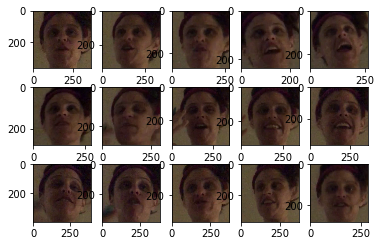

In [12]:
show(mtcnn.get_faces(frames))

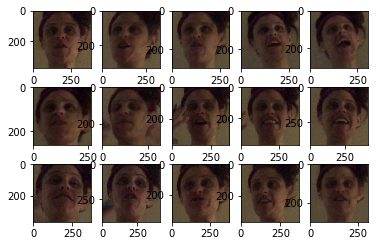

In [24]:
show(blaze.get_faces(frames))

In [15]:
%load_ext autoreload
%autoreload 2
# %debug

# refine validation

In [113]:
info = pd.DataFrame({"file": [fn.split("/")[-1] for fn in filenames], "label": labels, "predict": predictions}).set_index("file")
info['class'] = df['class']
info["loss"] = info.apply(lambda row: log_loss([row.label], [row.predict], labels=[0,1]), axis=1)
info.sort_values("loss", inplace=True, ascending=False)

In [70]:
info[info['class']==114]

label   predict class      loss
file                                           
qdwuhbpvep.mp4      1  0.972222   114  0.028172
ccdgiezfdv.mp4      1  0.974996   114  0.025322
wcybpkdnmv.mp4      1  0.982563   114  0.017591
idhqpwmptv.mp4      1  0.994870   114  0.005143
zphkhxzdke.mp4      1  0.996789   114  0.003216
pzirdftiaz.mp4      1  0.997734   114  0.002269
wtariodlhw.mp4      1  0.998162   114  0.001840
gmhtuubbqm.mp4      1  0.998347   114  0.001654
duqfwmozqw.mp4      1  0.998742   114  0.001259
faicwfivhj.mp4      1  0.998850   114  0.001150
xsdalwwoqy.mp4      1  0.999612   114  0.000388
shikzxipov.mp4      1  0.999641   114  0.000359
xflptzlkqc.mp4      1  0.999686   114  0.000314
gtfydughgx.mp4      1  0.999722   114  0.000278
etttsckqzg.mp4      1  0.999755   114  0.000245
hffpiwqxns.mp4      1  0.999778   114  0.000222
vomyajnckm.mp4      1  0.999933   114  0.000067

In [116]:
def vali(subinfo):
    pos = subinfo[subinfo.label==0].groupby(subinfo['class'])['loss'].mean()
    neg = subinfo[subinfo.label==1].groupby(subinfo['class'])['loss'].mean()
    return (pos+neg)/2

ret = vali(info)
ret1 = vali(info[info['predict'] <= 0.5])
ret0 = vali(info[info['predict'] > 0.5])
print(ret.mean(), ret1.mean(), ret0.mean())
print(len(info[info['predict'] <= 0.5]), len(info[info['predict'] > 0.5]), len(info[info['label']==0]), len(info[info['label']==1]))
ret
# ret[(ret.isin([np.nan])) | (ret<0.28)].index
# ret[ret>0.28].index
# np.nanmean((ret1+ret0)/2) # 15 151 172 175 183 199

0.7292173014523686 0.6635983738741983 1.1515727032074379
1198 8802 1463 8537


class
0      0.521146
1      0.528148
2      0.640679
3      0.720450
10     0.515702
12     0.498079
14     0.213850
15     0.454186
18     0.648980
20     0.210891
21     0.246457
22     0.470067
24     0.143480
32     1.433798
33     1.534901
35     1.522607
44     0.560995
62     0.678775
67     1.640573
69     0.551795
73     1.340486
82     0.482177
83     0.792378
92     0.126827
95     0.420202
98     0.581947
103    1.363914
108    1.777403
129    1.851912
135    0.803531
136    0.827768
138    0.263689
145    0.569861
150    0.676041
152    0.323037
158    0.160698
160    0.381598
164    0.727714
166    0.581274
167    0.359221
171    0.705754
176    0.513224
181    0.779363
186    1.490168
187    1.903365
191    0.594916
193    0.194347
195    0.674052
Name: loss, dtype: float64

In [92]:
drops = ret[(ret.isin([np.nan])) | (ret<0.28)].index
info2 = info.drop(info[info["class"].isin(drops)].index) 
print(len(info2) )

8108


In [93]:
# info2.groupby(info2['class']).count()
tret = vali(info2)
tret1 = vali(info[info['predict'] <= 0.5])
tret0 = vali(info[info['predict'] > 0.5])
np.nanmean((tret1+tret0)/2) # 15 151 172 175 183 199

0.8195279422979056

In [99]:
# metadata.loc[metadata['class'].isin(drops),"split_kailu"]=-1
metadata.T.to_json(f'/data/deepfake/metadata/metadata_half_dropped.json')

In [30]:
def show_faces(file_list, title = None):
    from settings import face_cache_path
    import matplotlib.pyplot as plt
    
    if '/' in file_list[0]:
        file_list = [fn.split("/")[-1] for fn in file_list]
    if '.' in file_list[0]:
        file_list = [fn.split(".")[0] for fn in file_list]
    if title is None:
        title = file_list
    
    nlen = len(file_list)
    colums = max(5, int(np.sqrt(nlen))//2)
    rows = (nlen+colums-1)//colums
    fig, axes = plt.subplots(rows , colums, figsize=(15, rows*(15/colums*1.2)))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    ax_ix = 0
    for fn, tt in tqdm(zip(file_list, title)):
        cache_path = os.path.join(face_cache_path, fn)
        files = os.listdir(cache_path)
        with open(os.path.join(cache_path, files[0]), 'rb') as f:
            face = Image.open(f)
            face.load()
            image = np.array(face)
        
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(tt)
        ax_ix += 1

    plt.grid(False)
    plt.show()



0it [00:00, ?it/s]

28it [00:00, 274.74it/s]

53it [00:00, 263.69it/s]

81it [00:00, 267.37it/s]

100it [00:00, 261.81it/s]

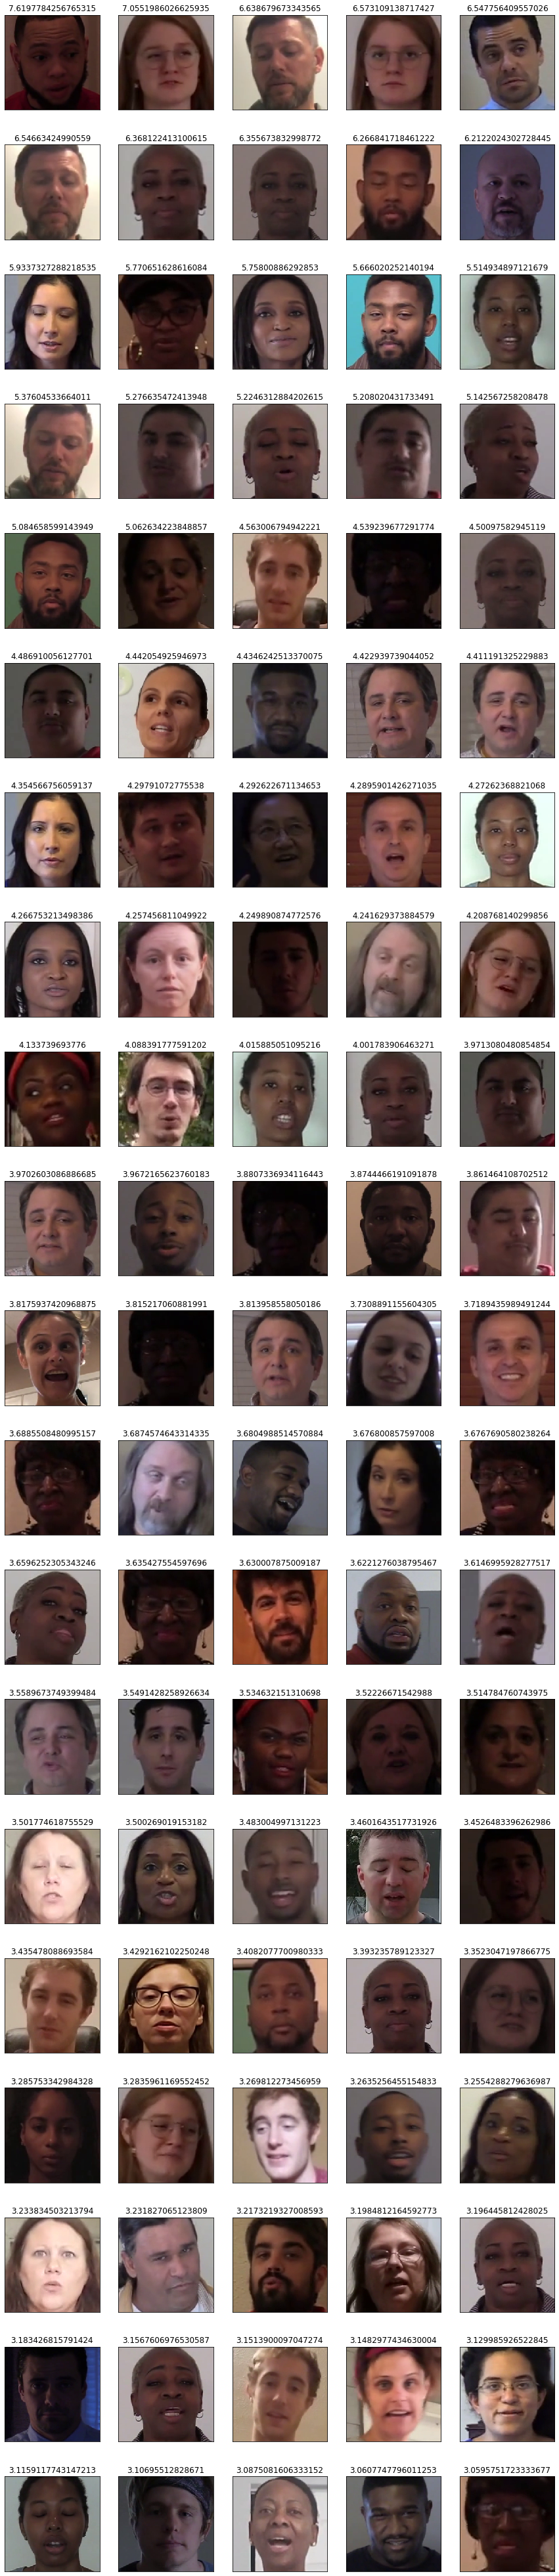

In [31]:
show_faces(info[info["label"]==0][:100].index, list(info[info["label"]==0][:100]["loss"]))



0it [00:00, ?it/s]

22it [00:00, 217.48it/s]

48it [00:00, 228.49it/s]

50it [00:00, 237.75it/s]

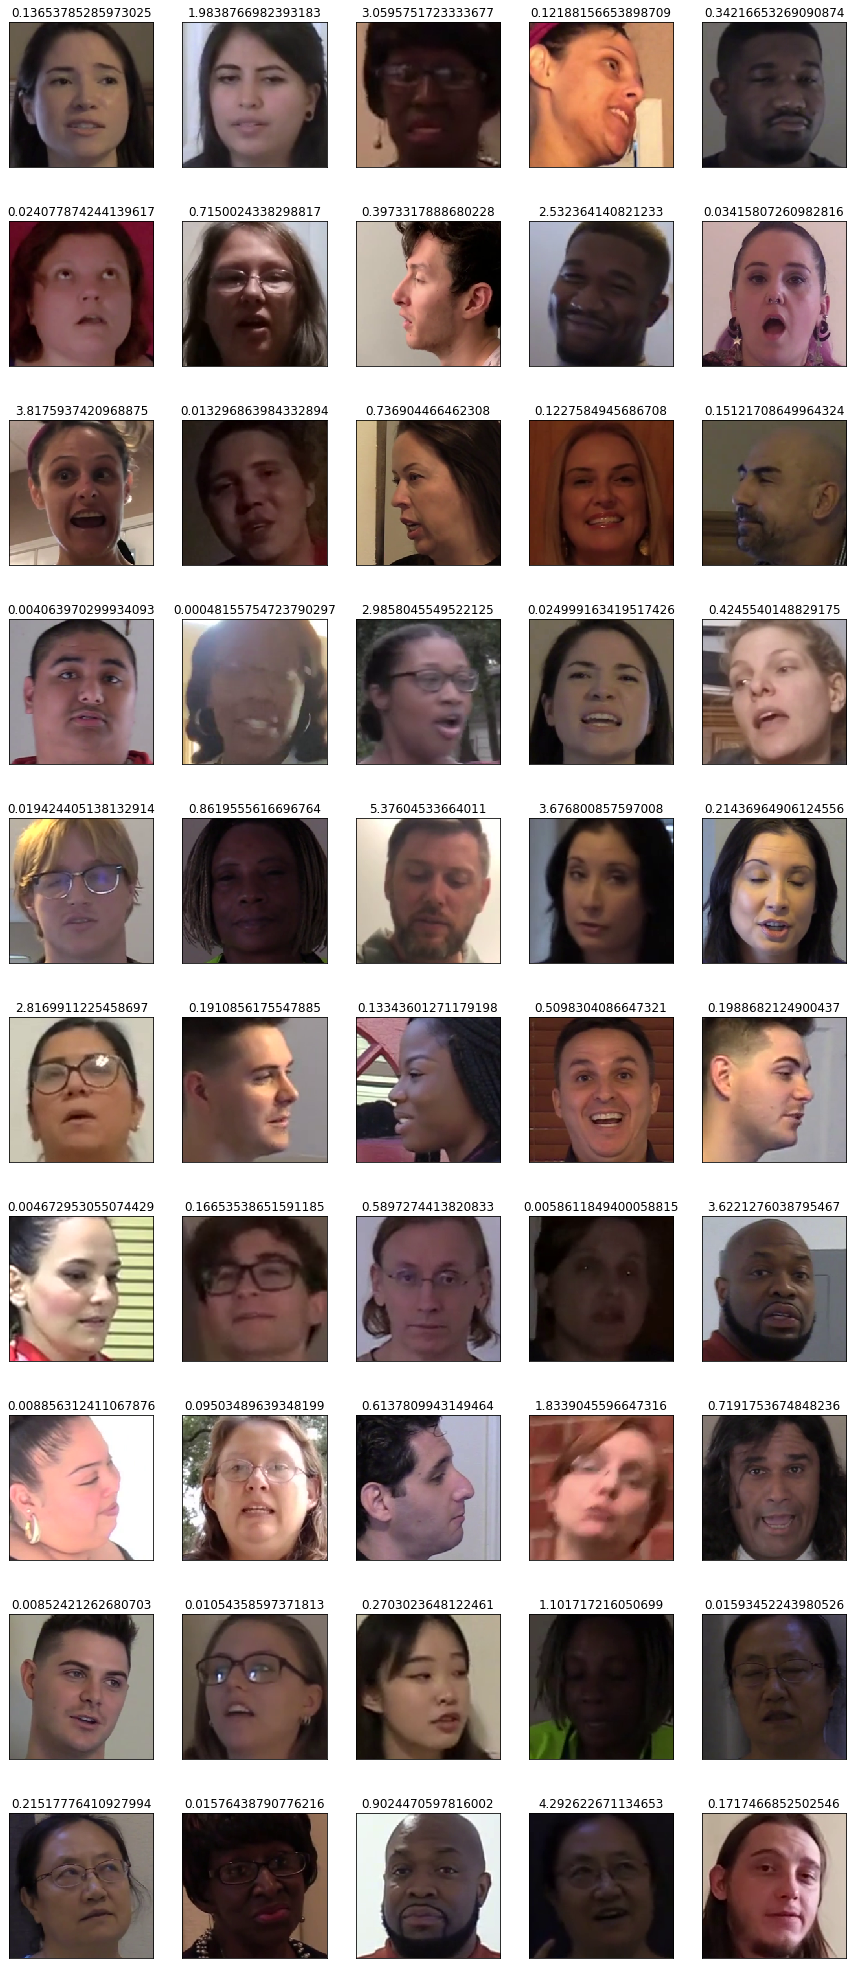

In [87]:
view = info[(info['label'] == 0) & (info['class'] == 10)].sample(50)
show_faces(view.index, list(view['loss']))